In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, wishart
from scipy.special import digamma
import data, random

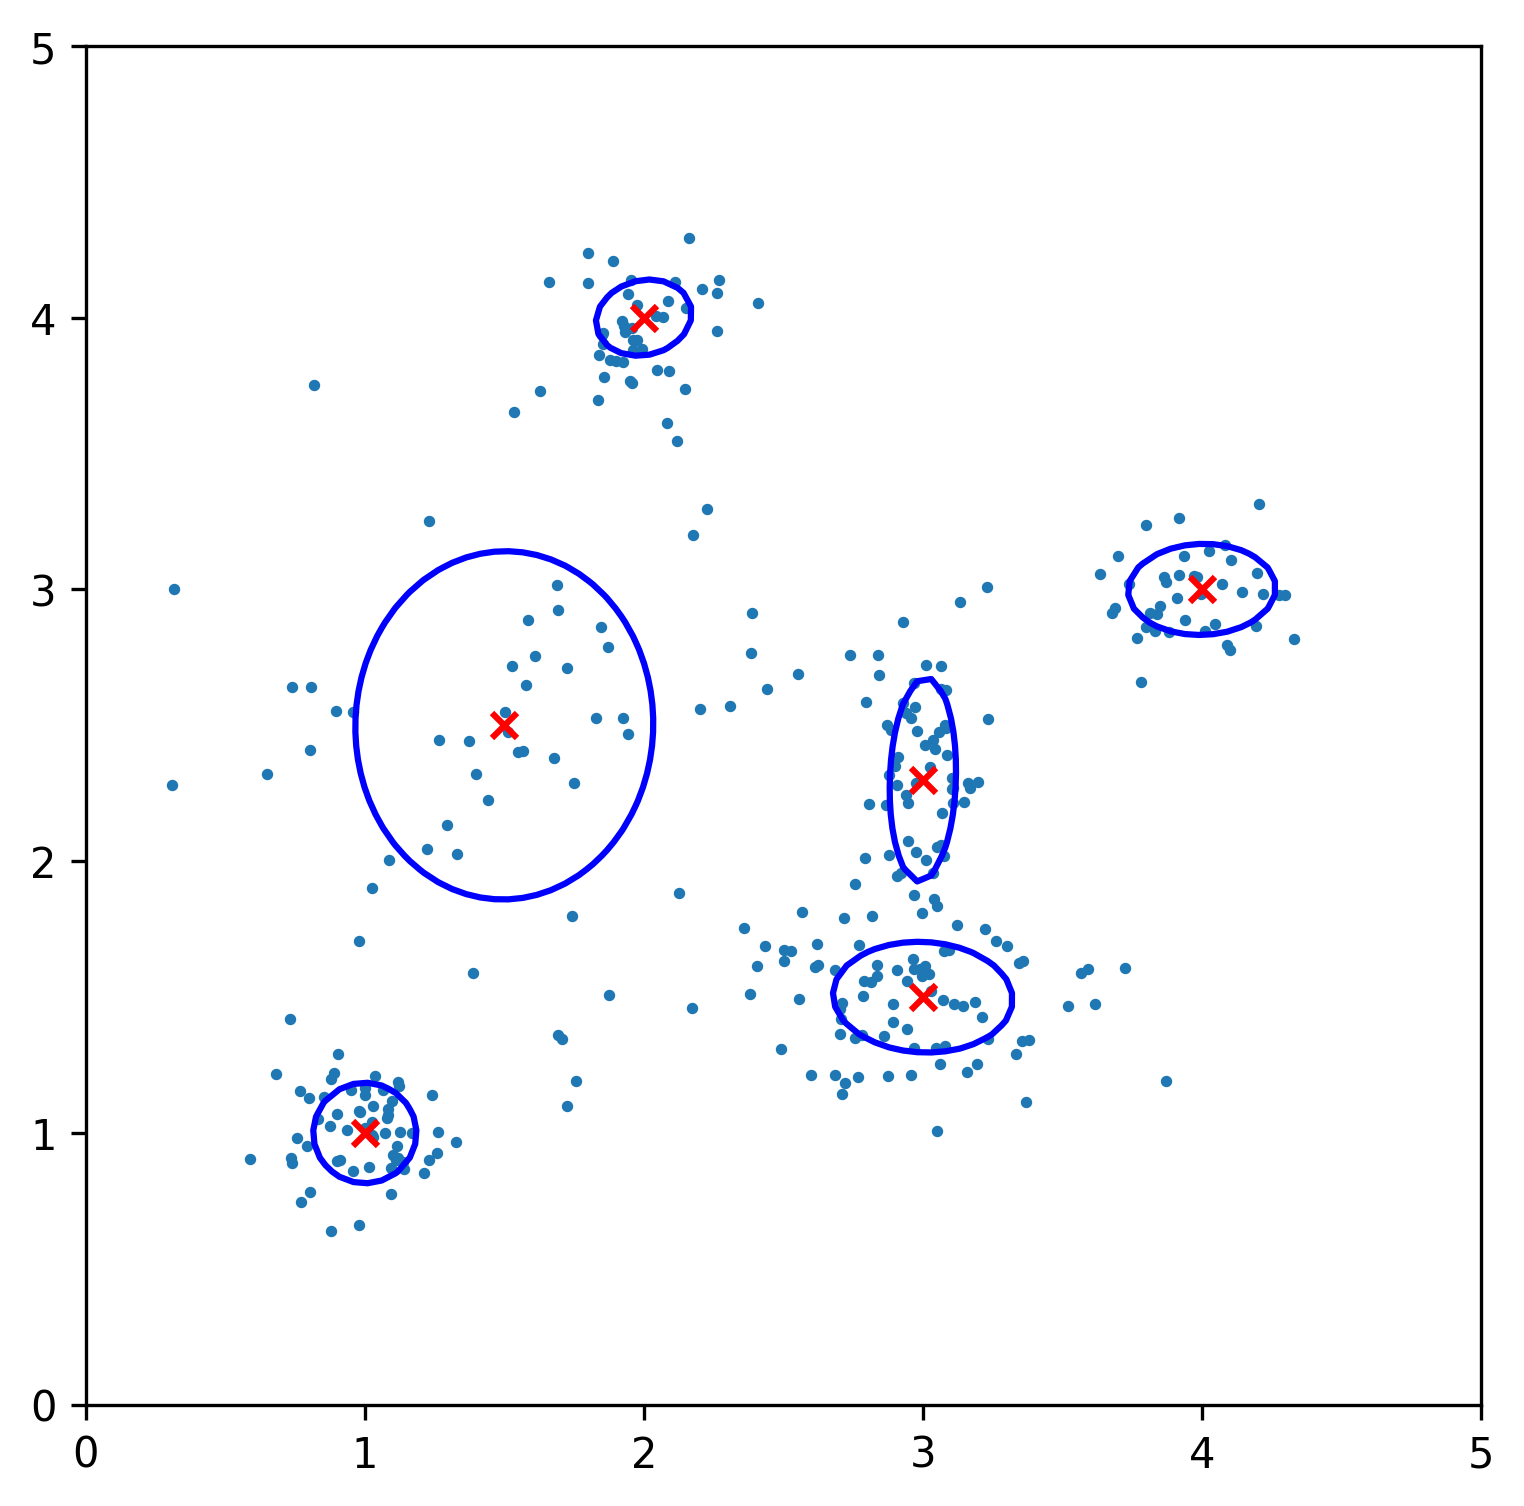

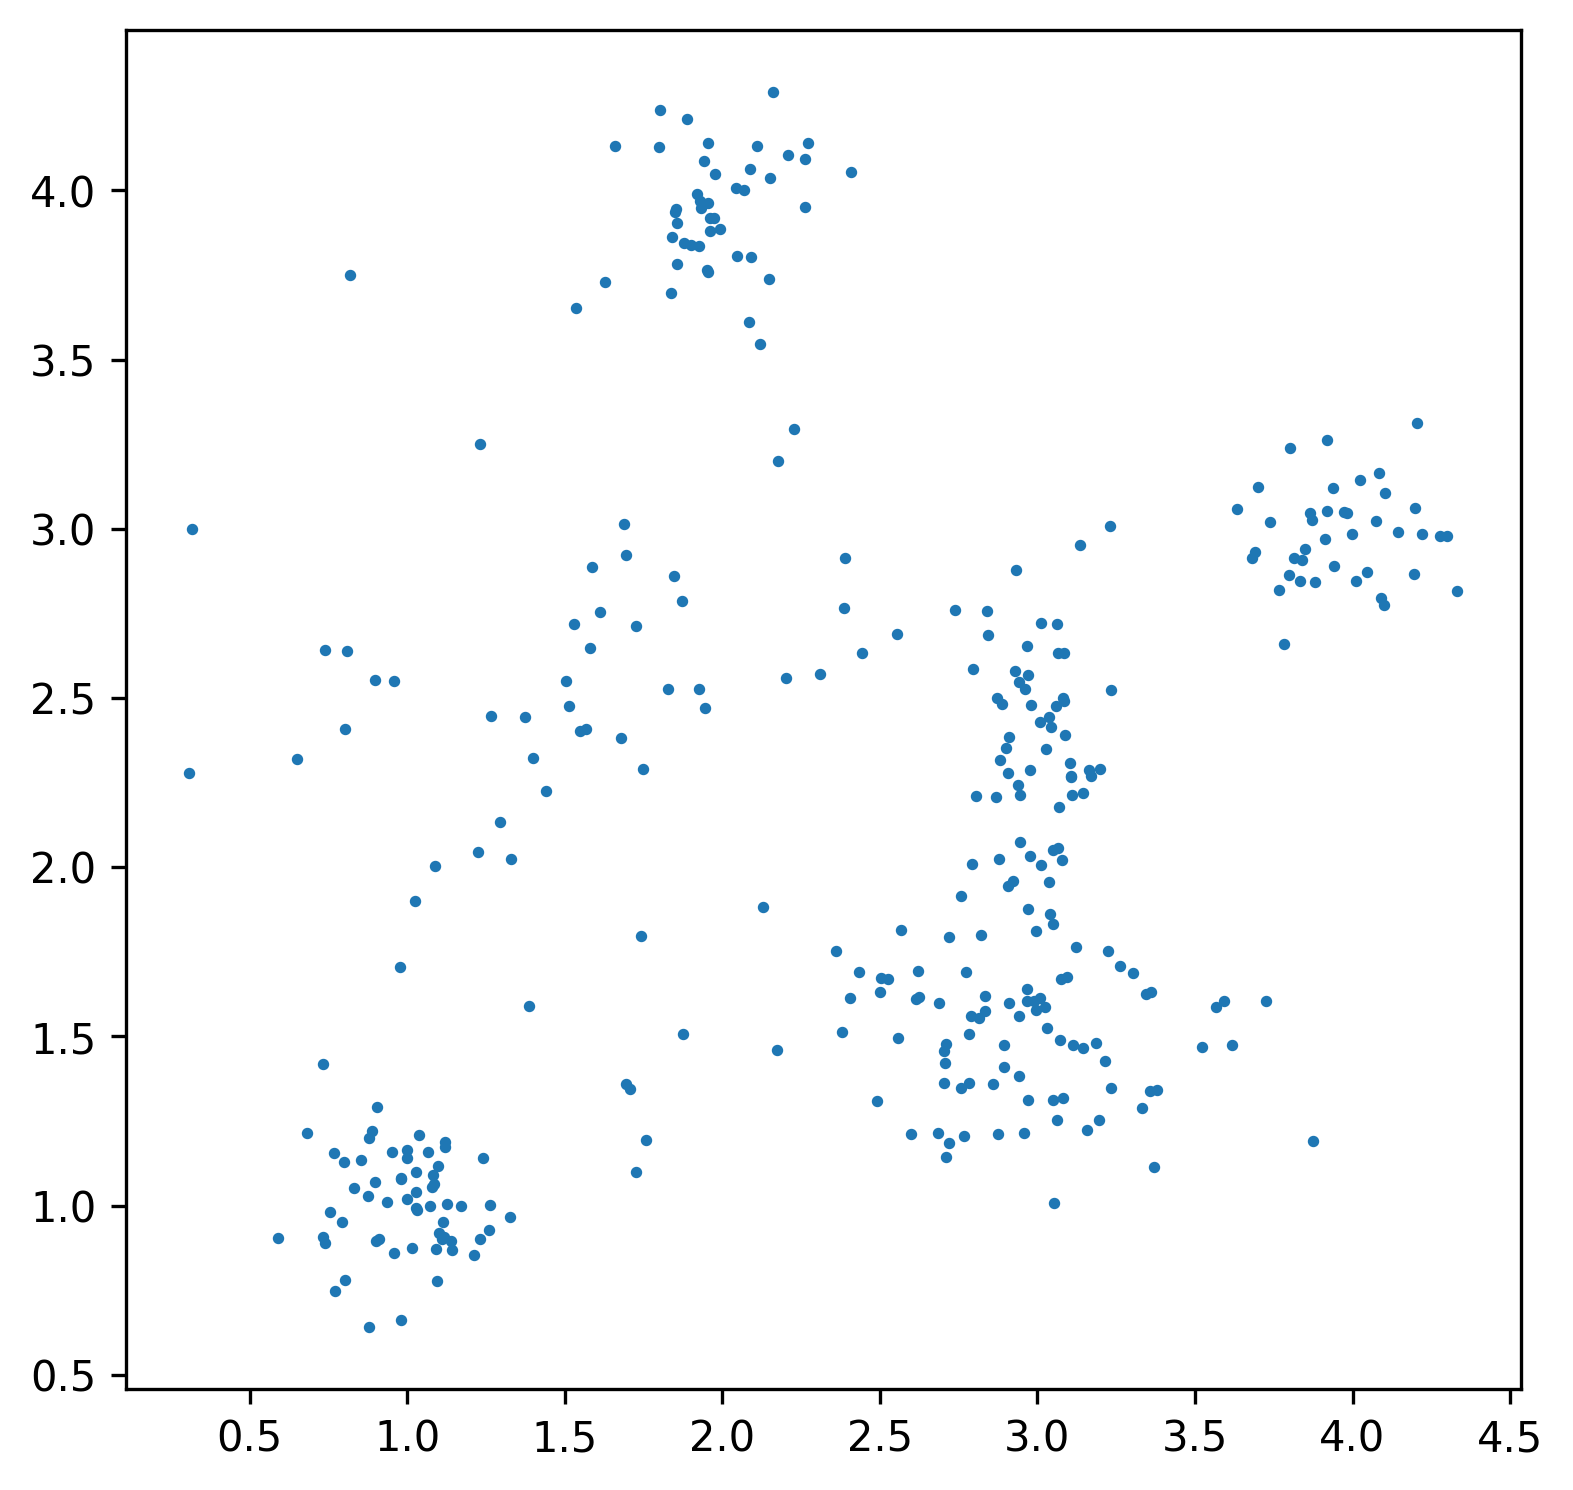

In [2]:
centers_x = [1, 1.5, 2,   3,   3, 4]
centers_y = [1, 2.5, 4, 1.5, 2.3, 3]
covs = [np.array([[3, 0],[0, 3]])/100, 
        np.array([[25, 0.3],[0.3, 36]])/100,
        np.array([[3, 0.3],[0.3, 2]])/100,
        np.array([[10, -0.3],[-0.3, 4]])/100,
        np.array([[1, 0.3],[0.3, 10]])/100, 
        np.array([[5, 0.1],[0.1, 2]])/100]
datanums = [60, 60, 40, 80, 60, 40]

K = 10

data = []

for i in range(len(centers_x)):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i])
    data.extend(p.rvs(datanums[i]))
    
#random.shuffle(data)
data.sort(key = lambda x: x[0])
#print(data)

#plt.scatter([x for (x,y) in data], [y for (x,y) in data])

def graph0(data):
    plt.figure(figsize=(6, 6), dpi=300)
    plt.scatter([x for (x,y) in data], [y for (x,y) in data], marker="o", s=3)
    
    normals = [multivariate_normal(mean=(centers_x[k],centers_y[k]), cov=covs[k]) for k in range(len(centers_x)) ]
    
    x, y = np.mgrid[0:5:100j, 0:5:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if k < 6:
            plt.scatter(centers_x[k],centers_y[k], color="red", marker="x")
            plt.contour(x, y, n.pdf(pos), levels=1, colors="b") 
            
    plt.show()
    

graph0(data)

def graph1(data):
    plt.figure(figsize=(6, 6), dpi=300)
    plt.scatter([x for (x,y) in data], [y for (x,y) in data], marker="o", s=3)
    
    normals = [multivariate_normal(mean=(centers_x[k],centers_y[k]), cov=covs[k]) for k in range(len(centers_x)) ]
    
    x, y = np.mgrid[0:5:100j, 0:5:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 
            
    plt.show()
    

graph1(data)

In [3]:

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        p = int(i/len(data)*K)
        r[p] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [7]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [8]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [9]:
def graph(data, ms, betas, w_invs, ns):
    plt.figure(figsize=(6, 6), dpi=300)
    plt.scatter([x for (x,y) in data], [y for (x,y) in data], marker="o", s=3)
    sigmas = [ w_invs[k]/betas[k]/2 for k in range(K)]
    
    normals = [multivariate_normal(mean=ms[k], cov=sigmas[k]) for k in range(K) ]
    
    x, y = np.mgrid[0:5:100j, 0:5:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if ns[k] > 1:
            plt.scatter(ms[k][0], ms[k][1], color="red", marker="x")
            plt.contour(x, y, n.pdf(pos), levels=1, colors="b") 
            
    plt.show()
    

In [10]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

In [11]:

def one_step(rs, draw=False):
    ns = [weighted_num(k, rs) for k in range(K)]
    xs = [weighted_mean(k, rs, data) for k in range(K)]
    covs = [weighted_cov(k, rs, data) for k in range(K)]

    for k in range(K):
        if ns[k] < 0.01:
            continue
            
        params = update_params(1,1,1, np.mean(data), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
        alphas[k] = params[0]
        betas[k] = params[1]
        nus[k] = params[2]
        ms[k] = params[3]
        w_invs[k] = params[4]

  
    if draw:
        plt.figure()
        graph(data, ms, betas, w_invs, ns)
    return calc_rs(alphas, betas, nus, ms, w_invs)
    
#    print(alphas)
#    print(betas)
#    print(nus)

#    print(w_invs)
#    print(ms) 
#    print(rs)

初期の負担率から


<Figure size 432x288 with 0 Axes>

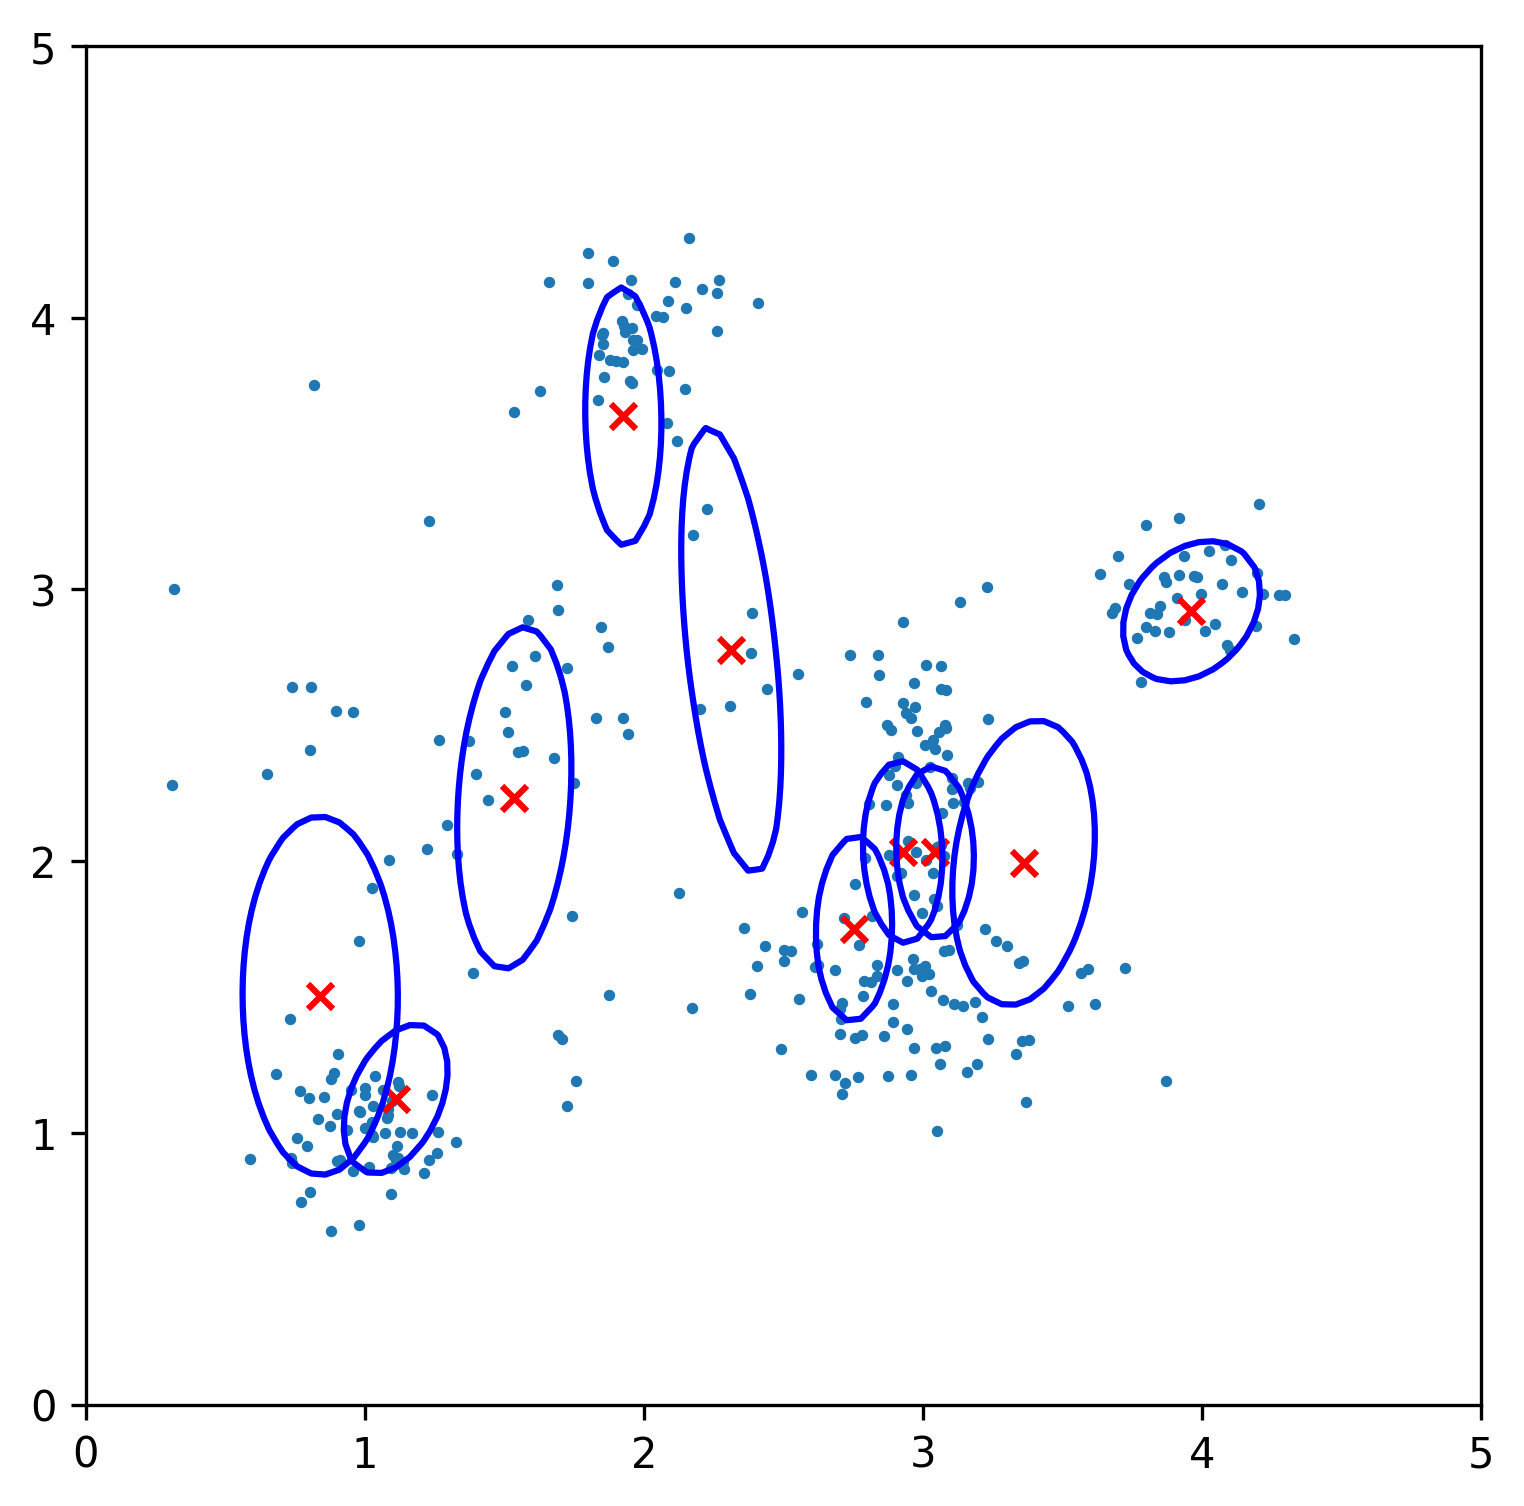

In [12]:
print("初期の負担率から")
rs = one_step(rs, True)

5回目


<Figure size 432x288 with 0 Axes>

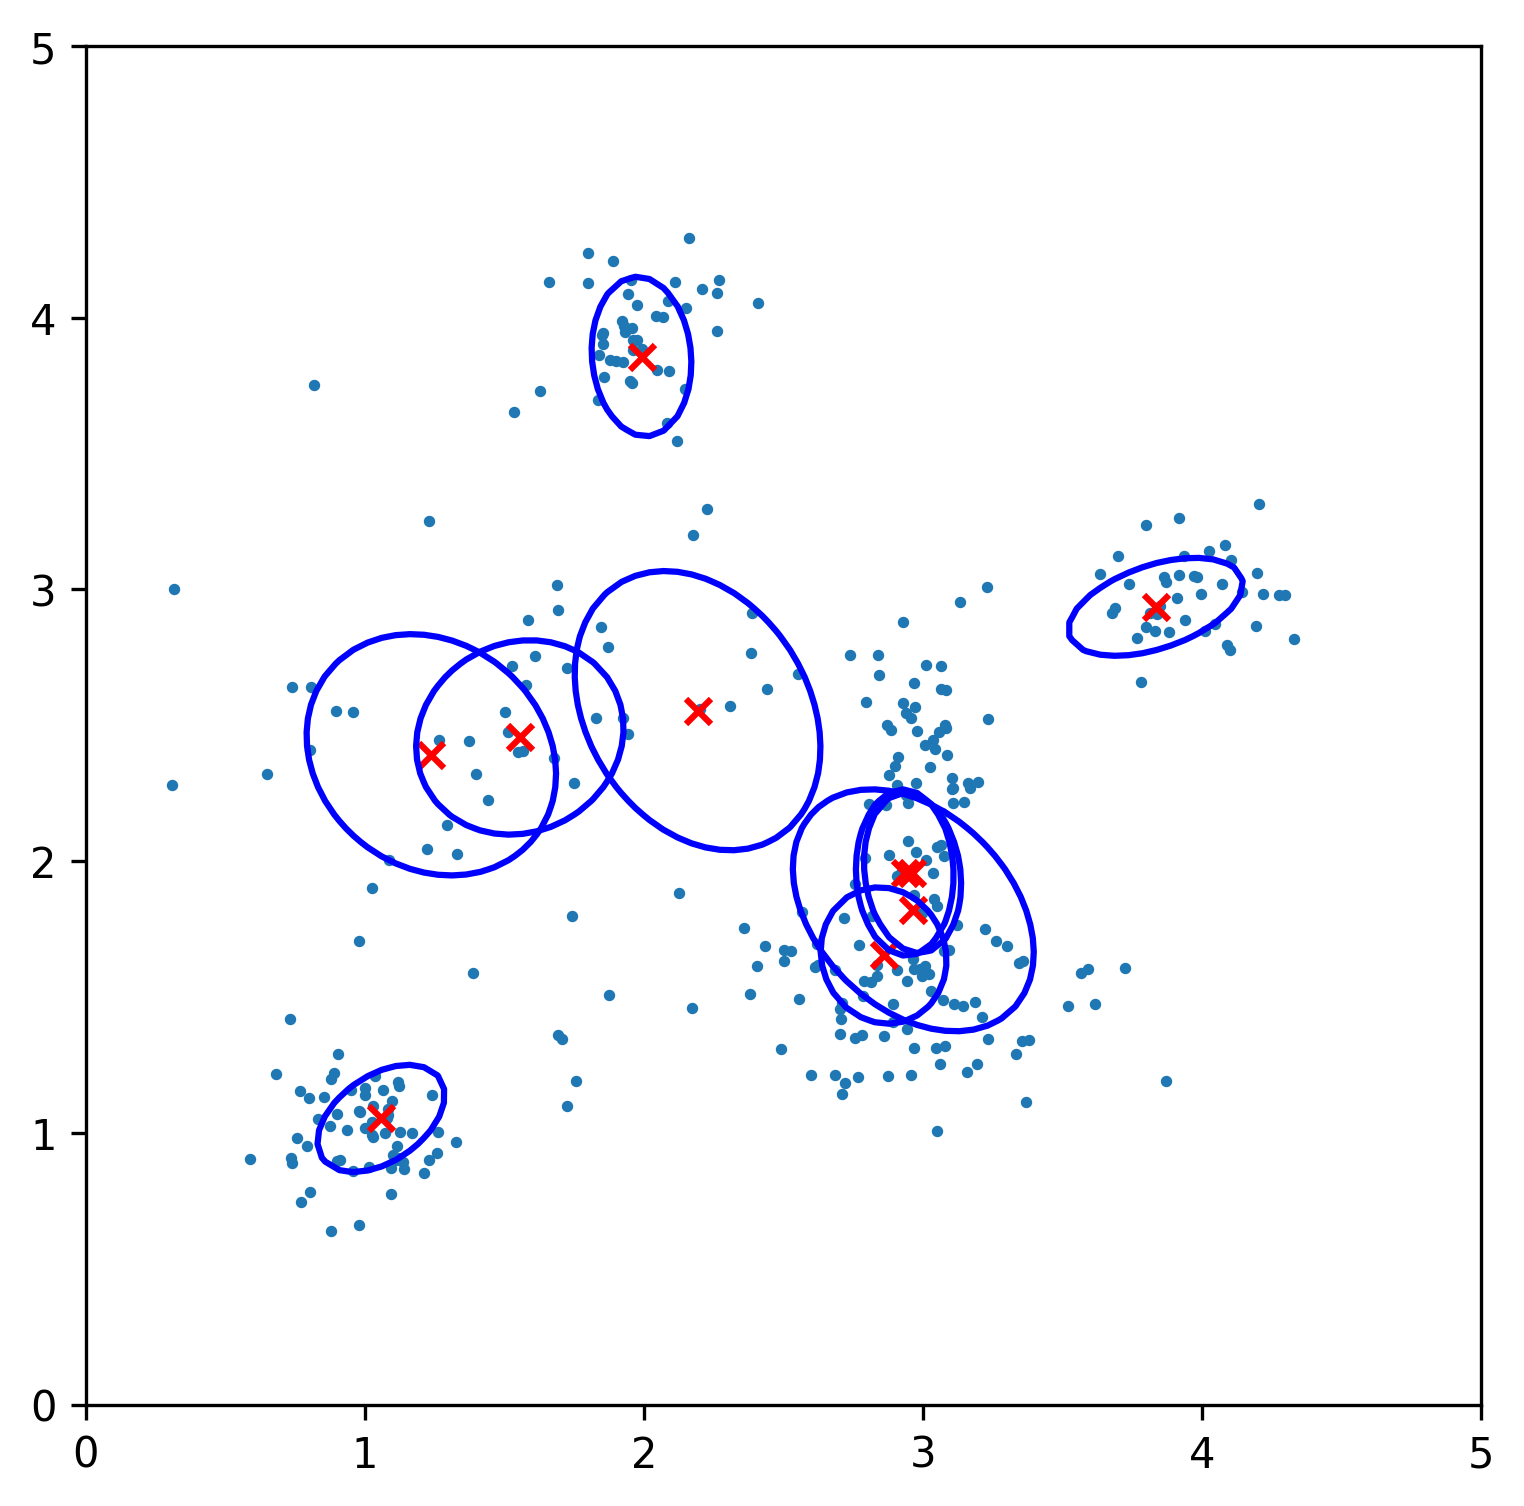

10回目


<Figure size 432x288 with 0 Axes>

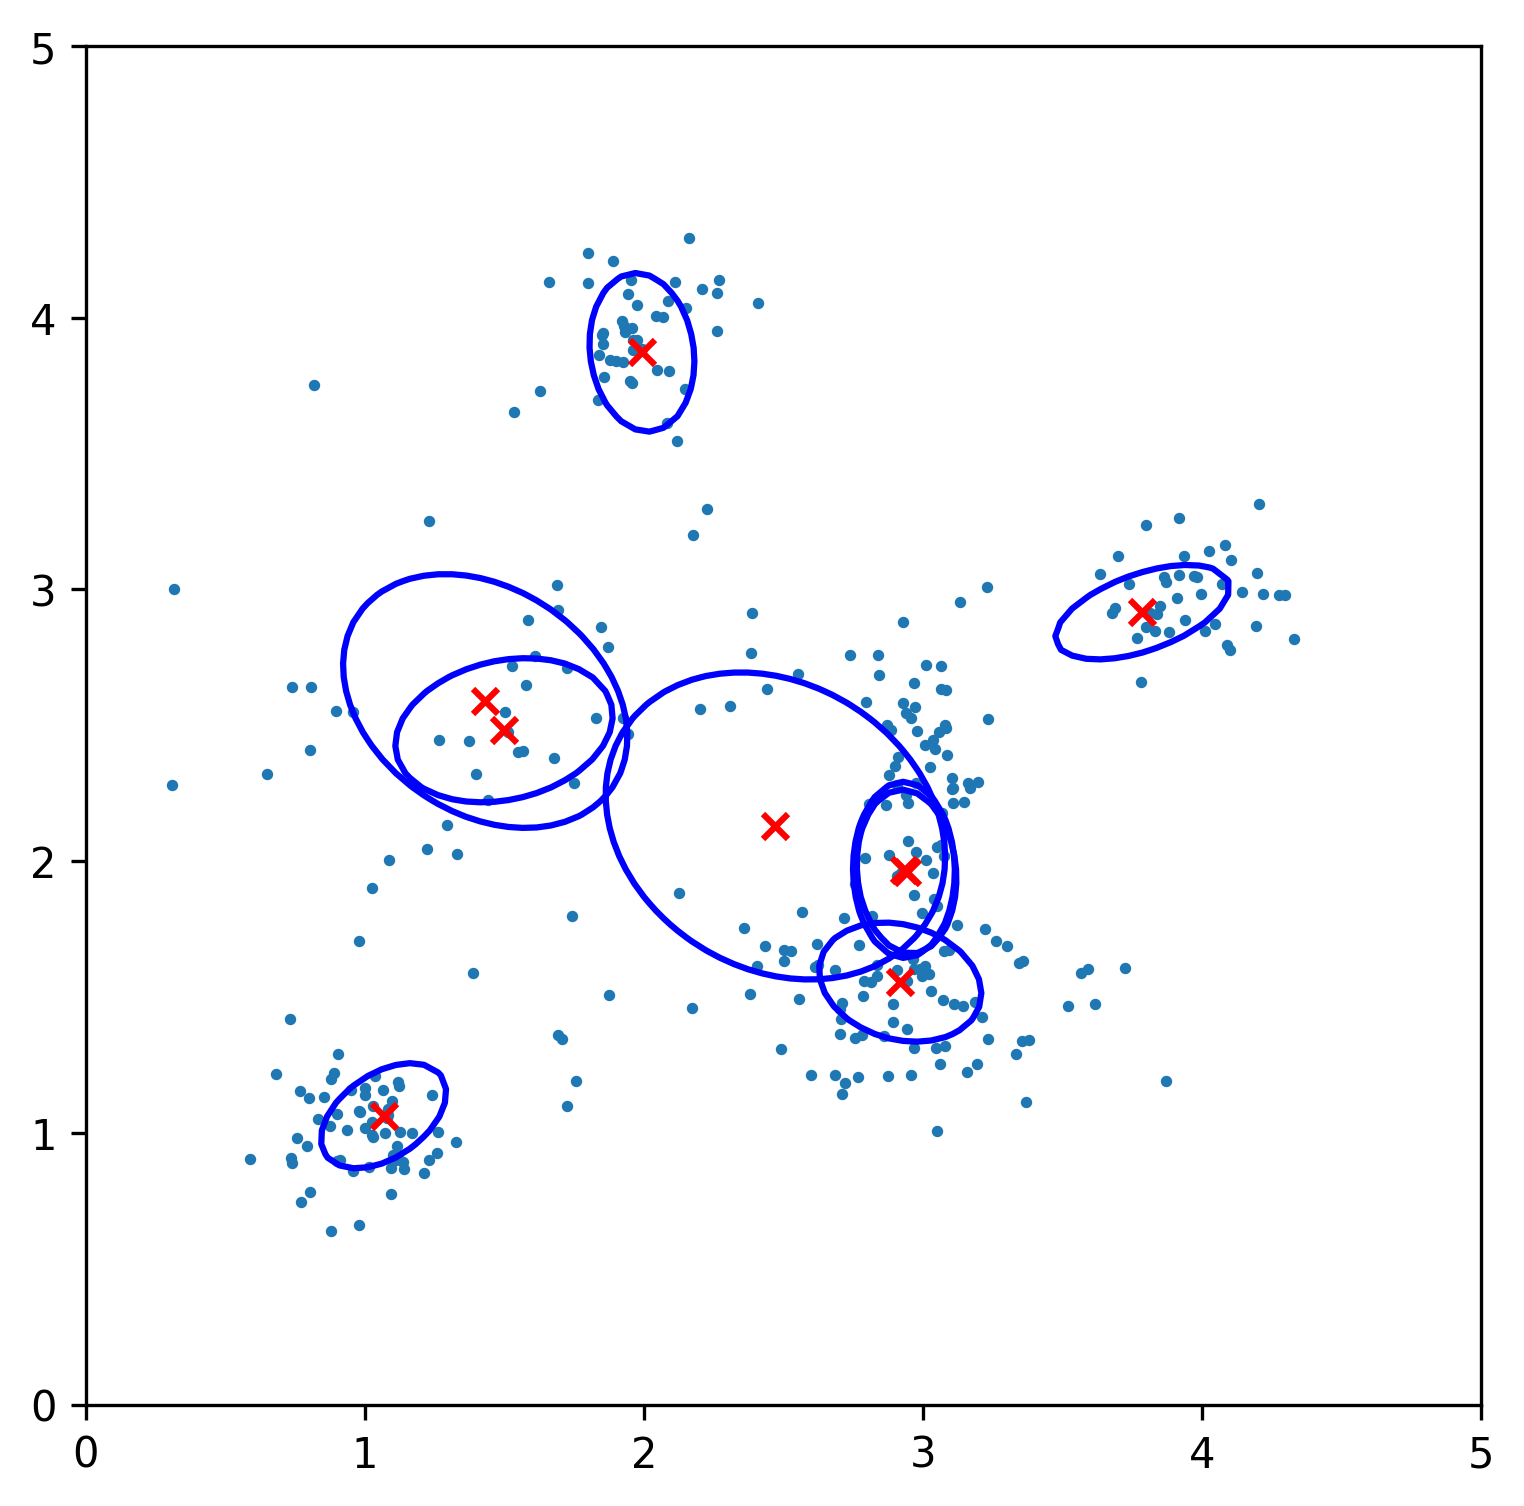

15回目


<Figure size 432x288 with 0 Axes>

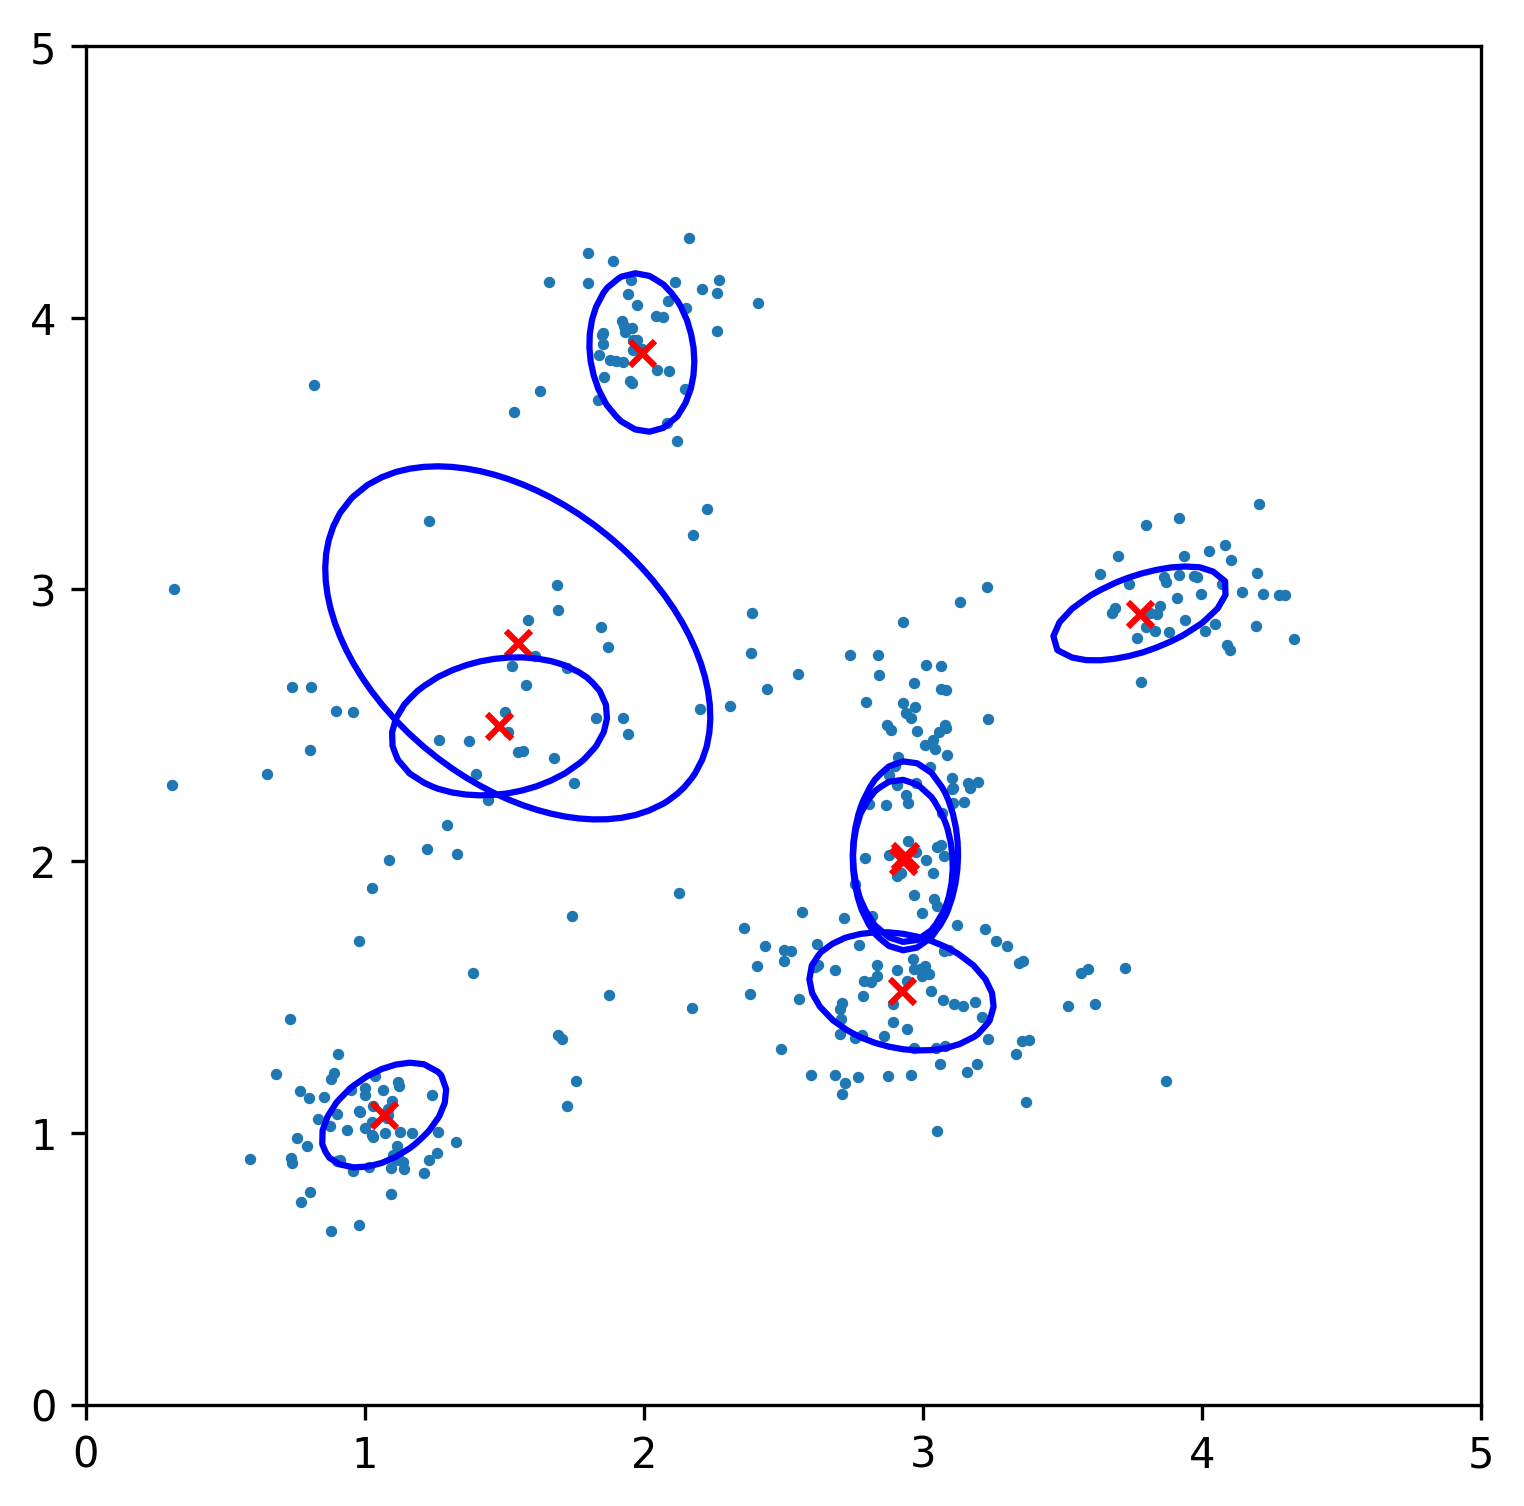

20回目


<Figure size 432x288 with 0 Axes>

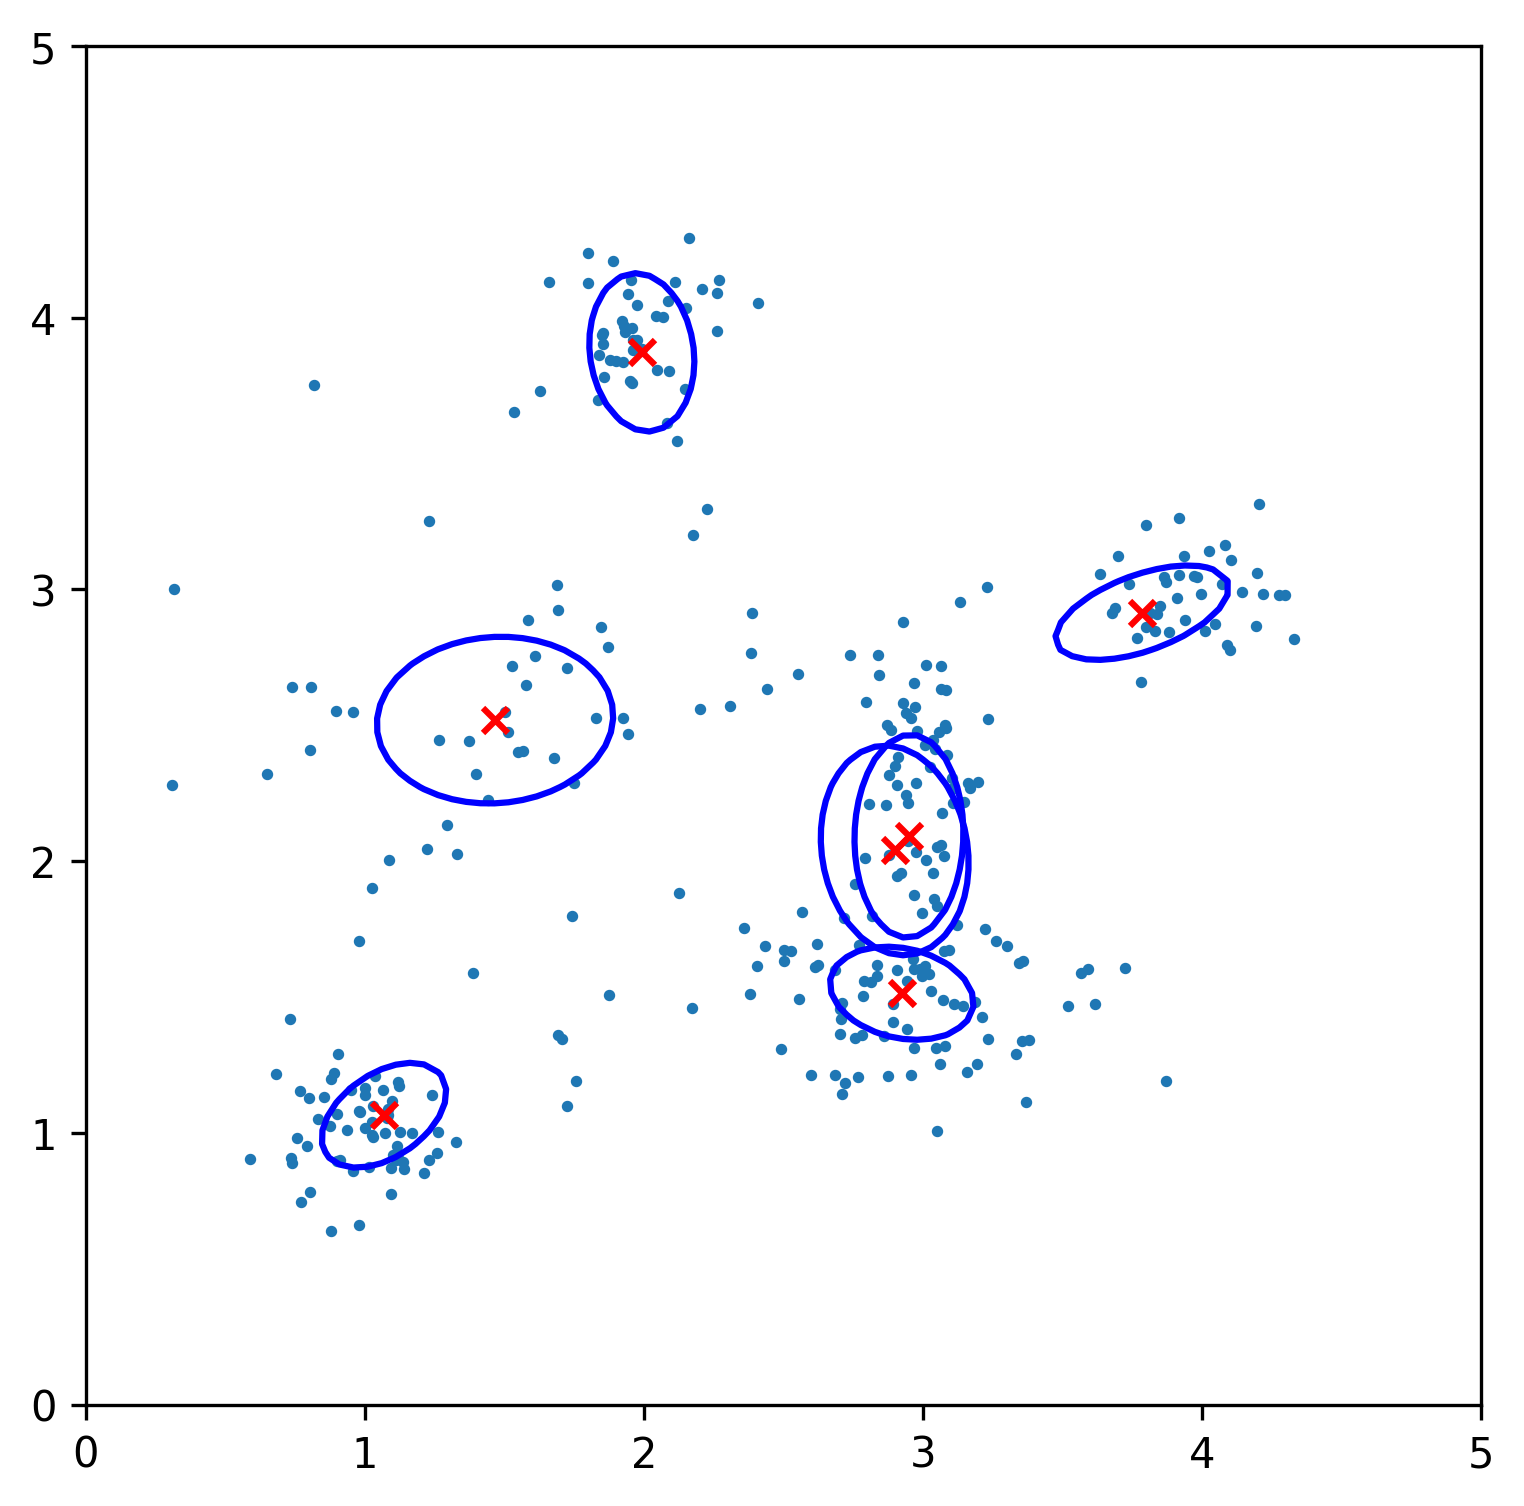

25回目


<Figure size 432x288 with 0 Axes>

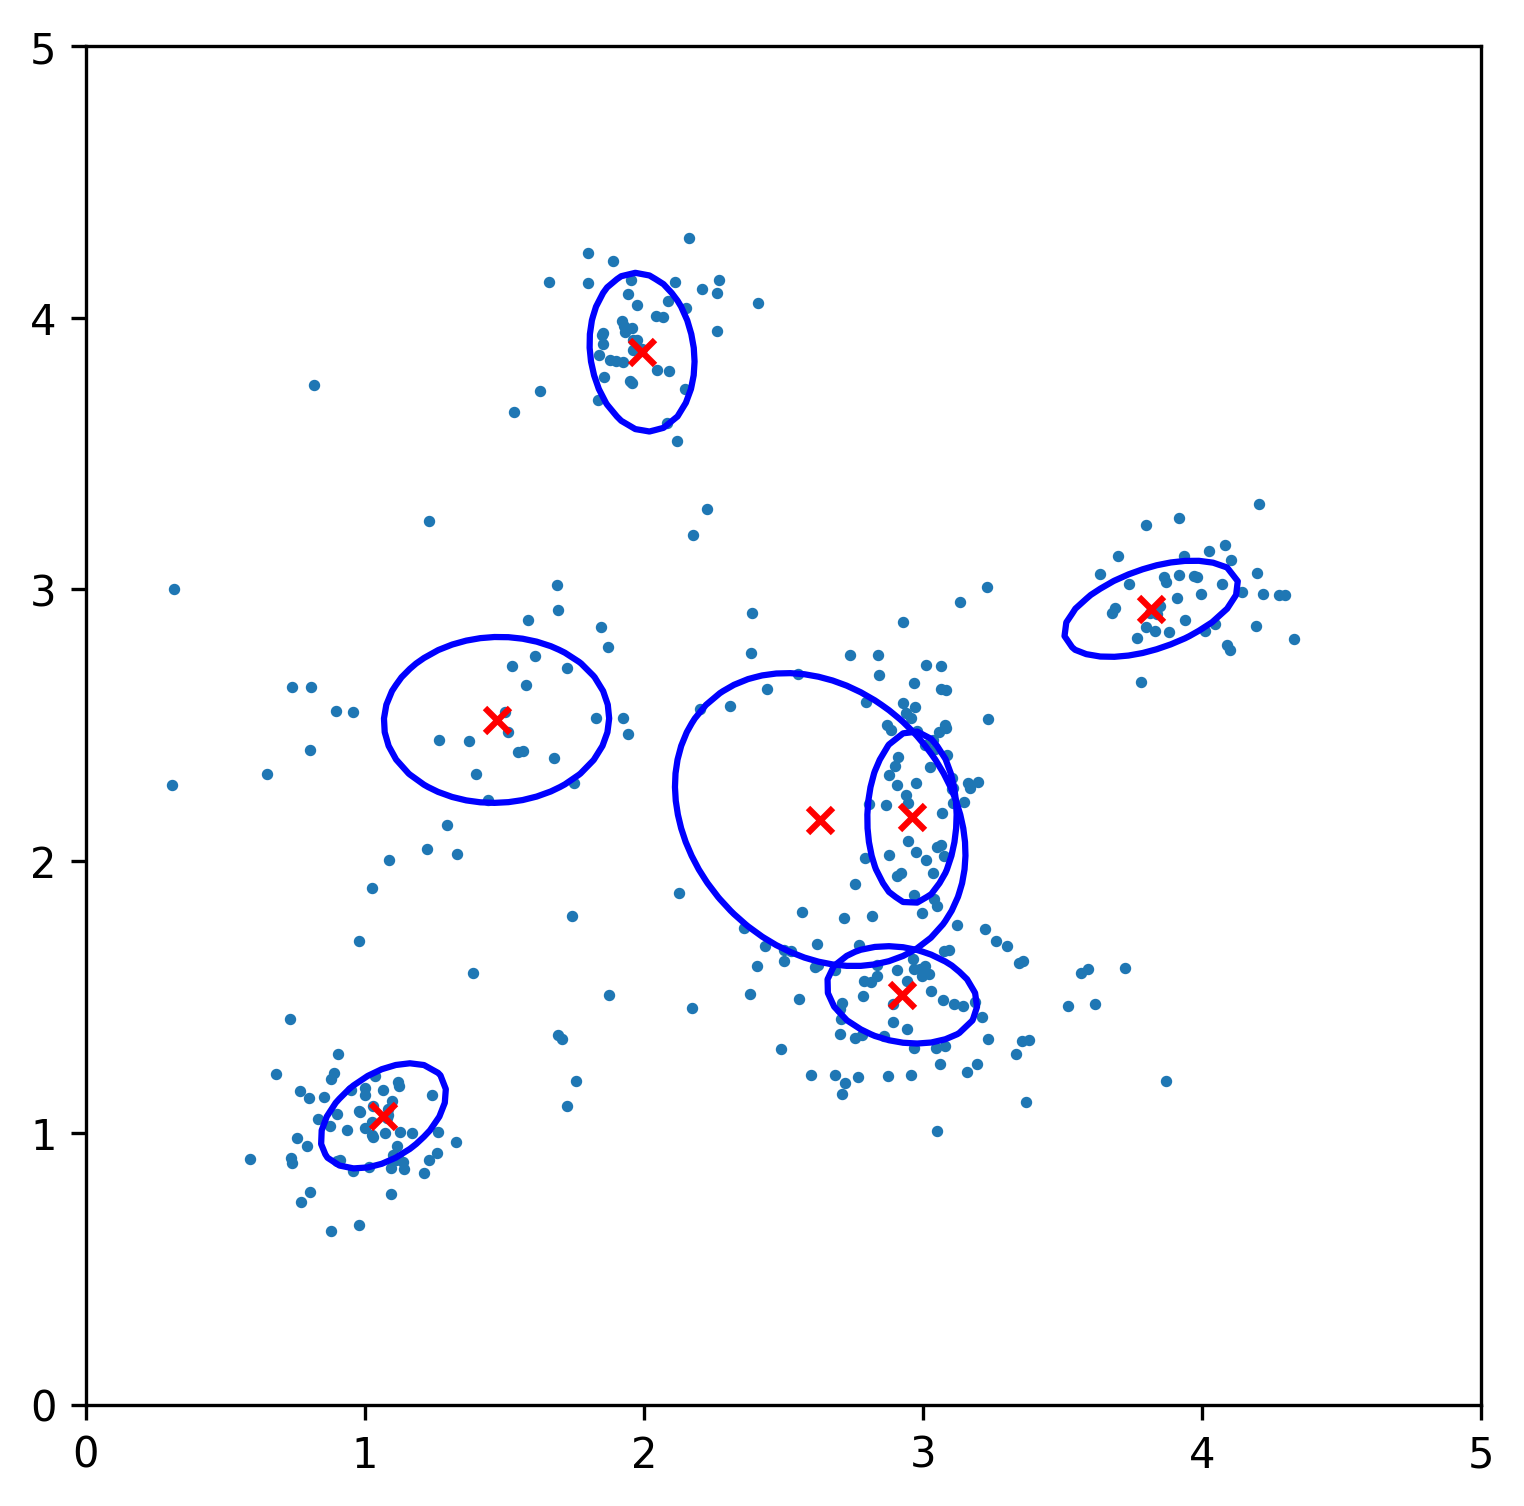

30回目


<Figure size 432x288 with 0 Axes>

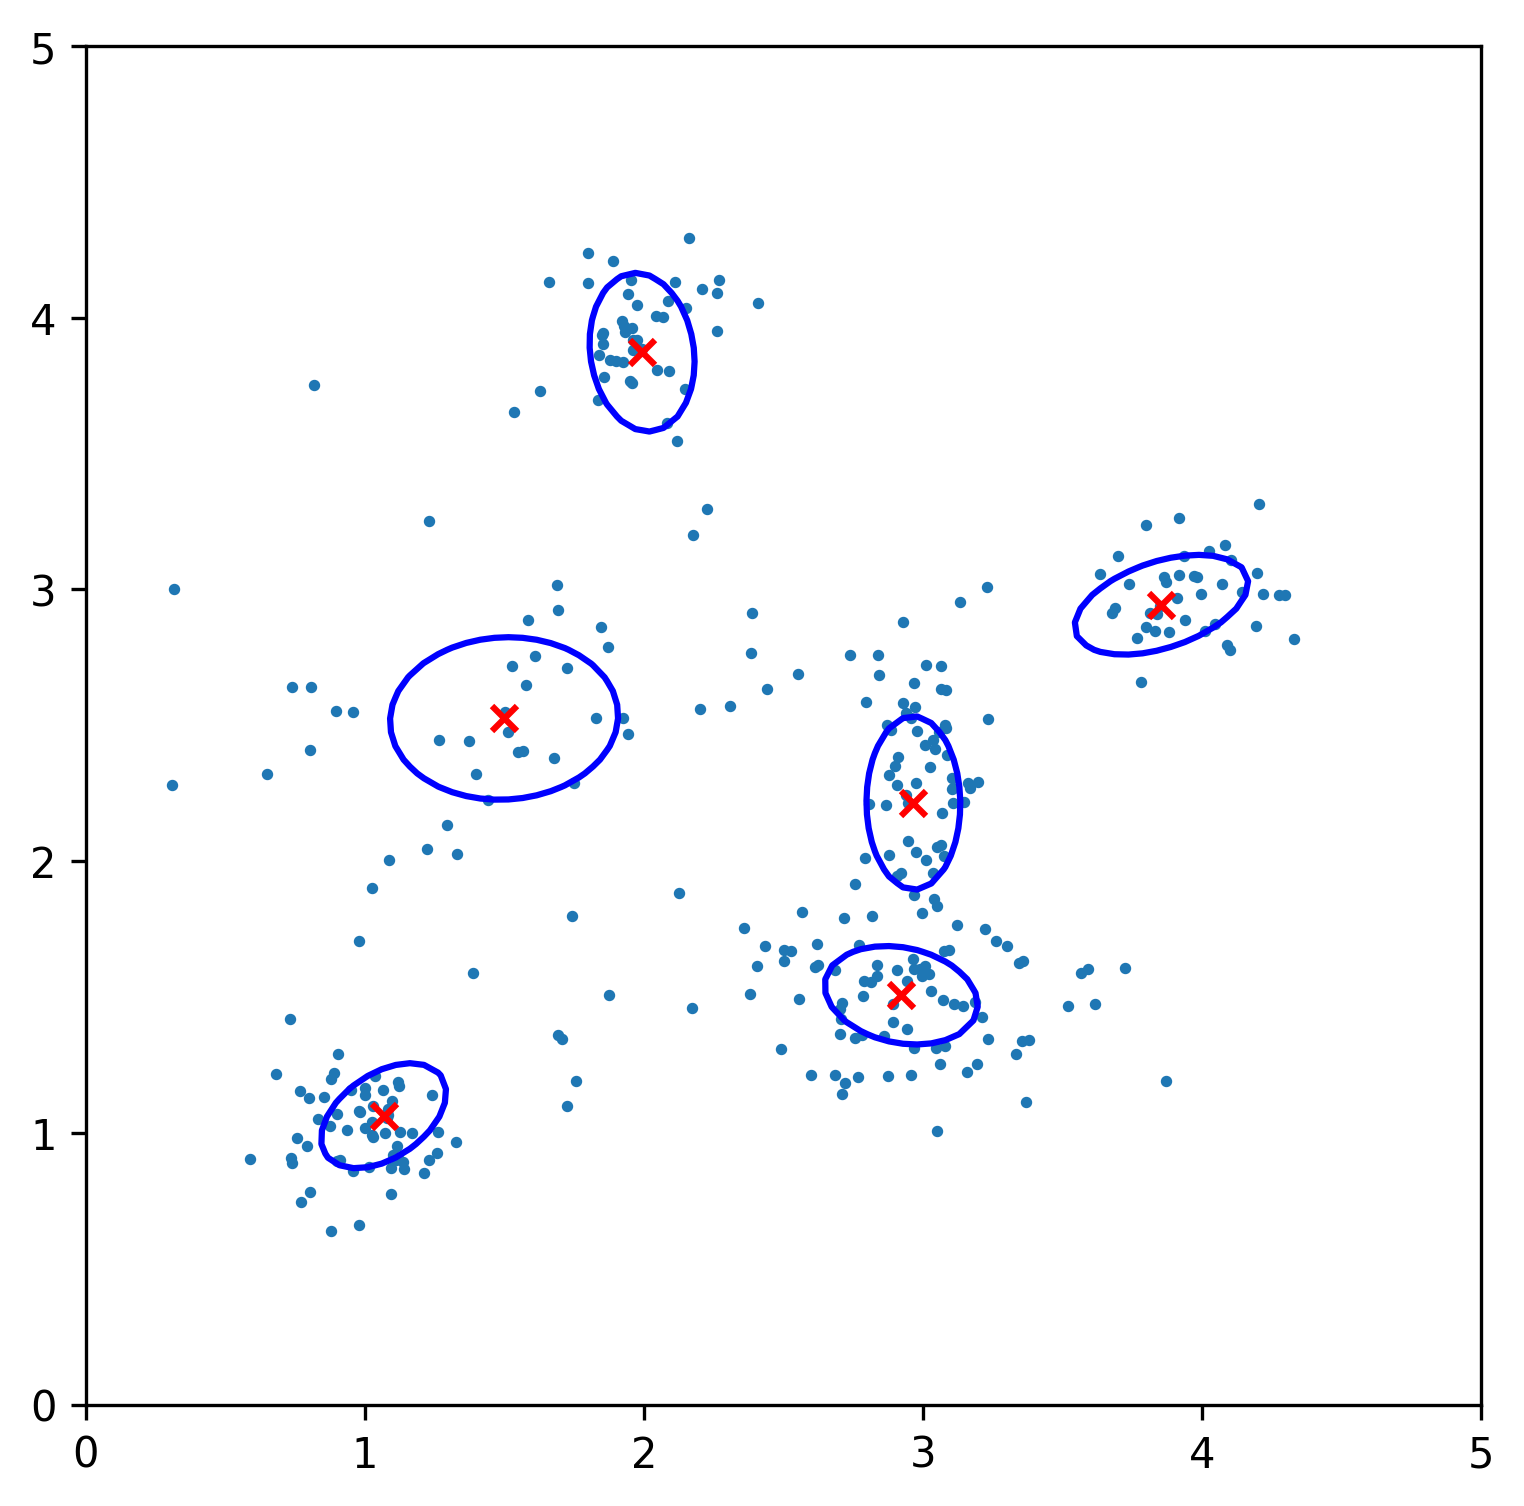

35回目


<Figure size 432x288 with 0 Axes>

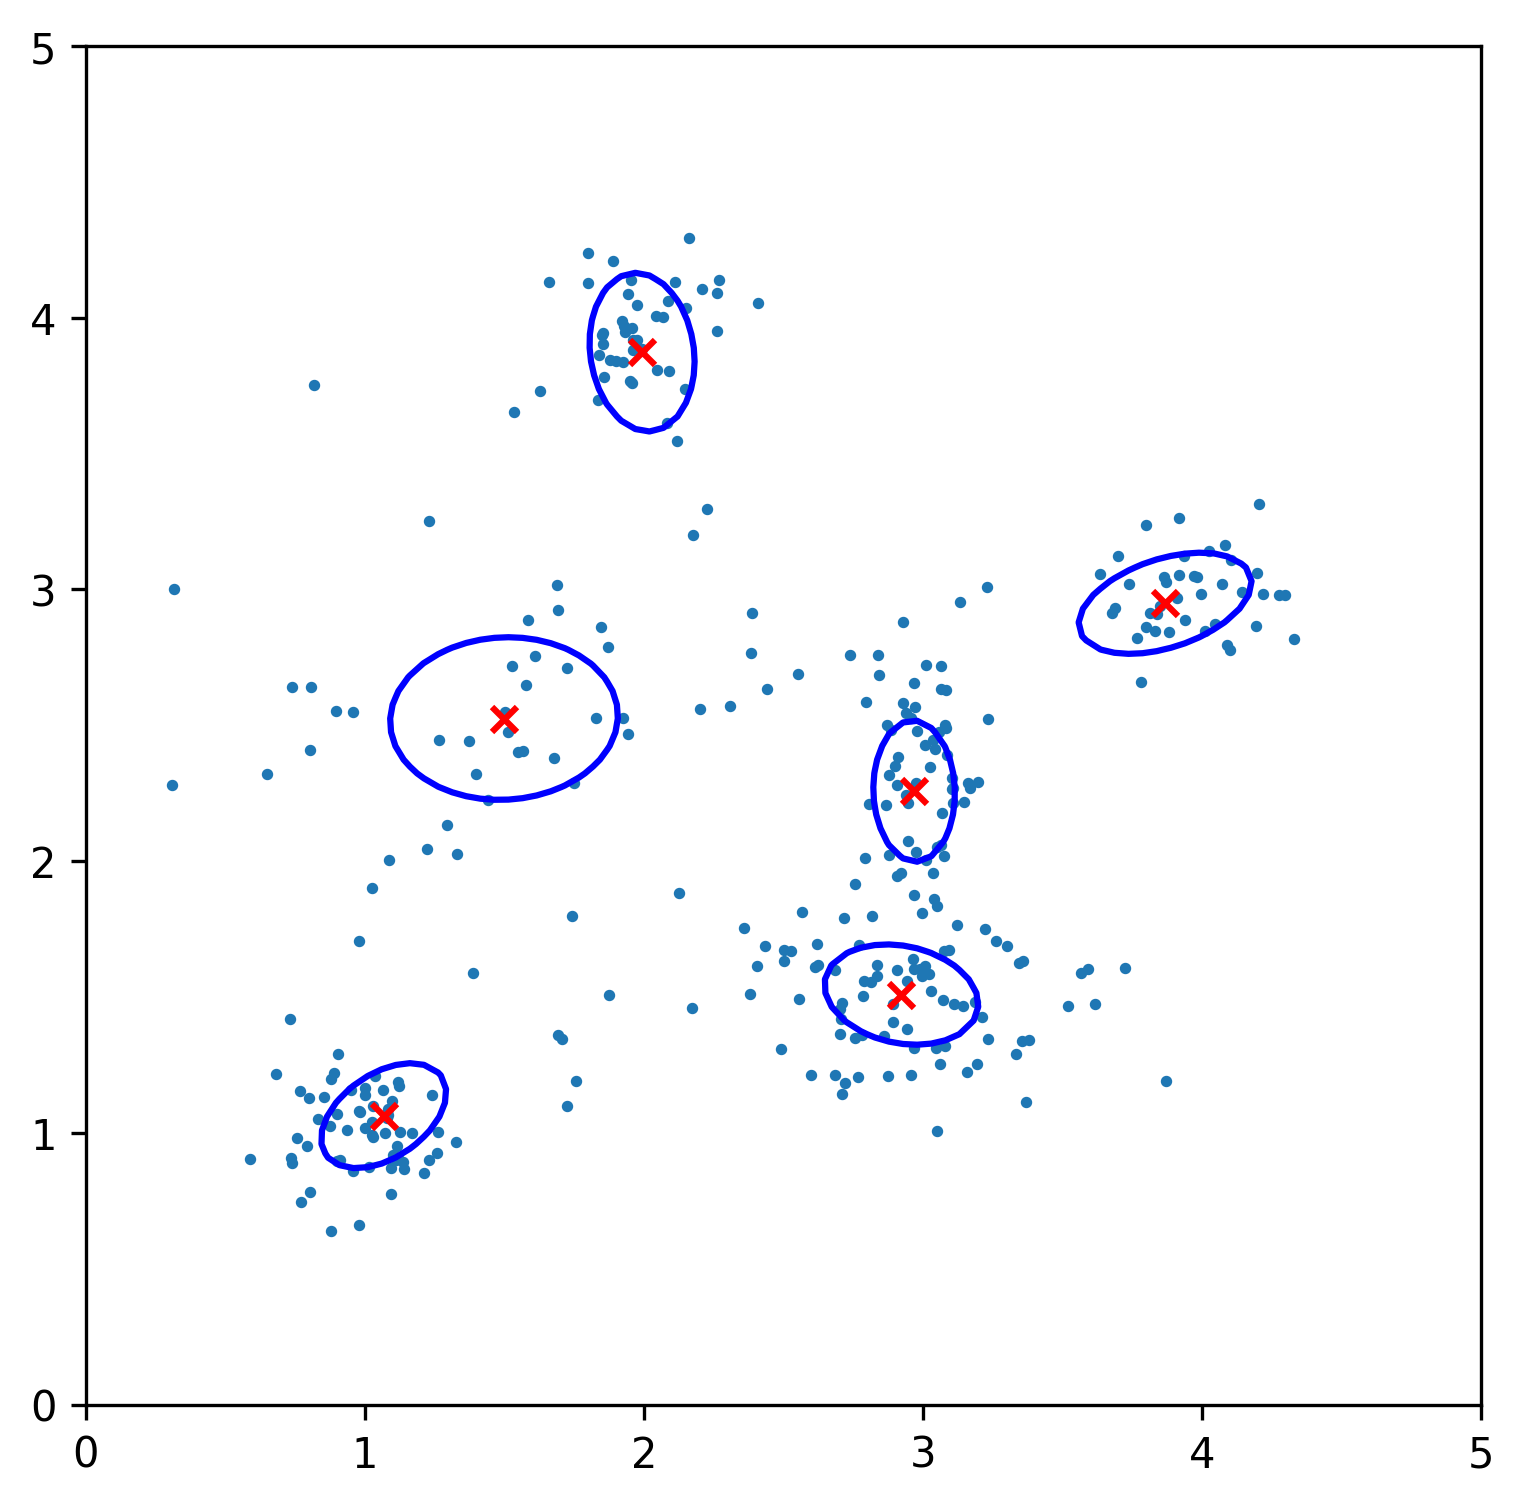

40回目


<Figure size 432x288 with 0 Axes>

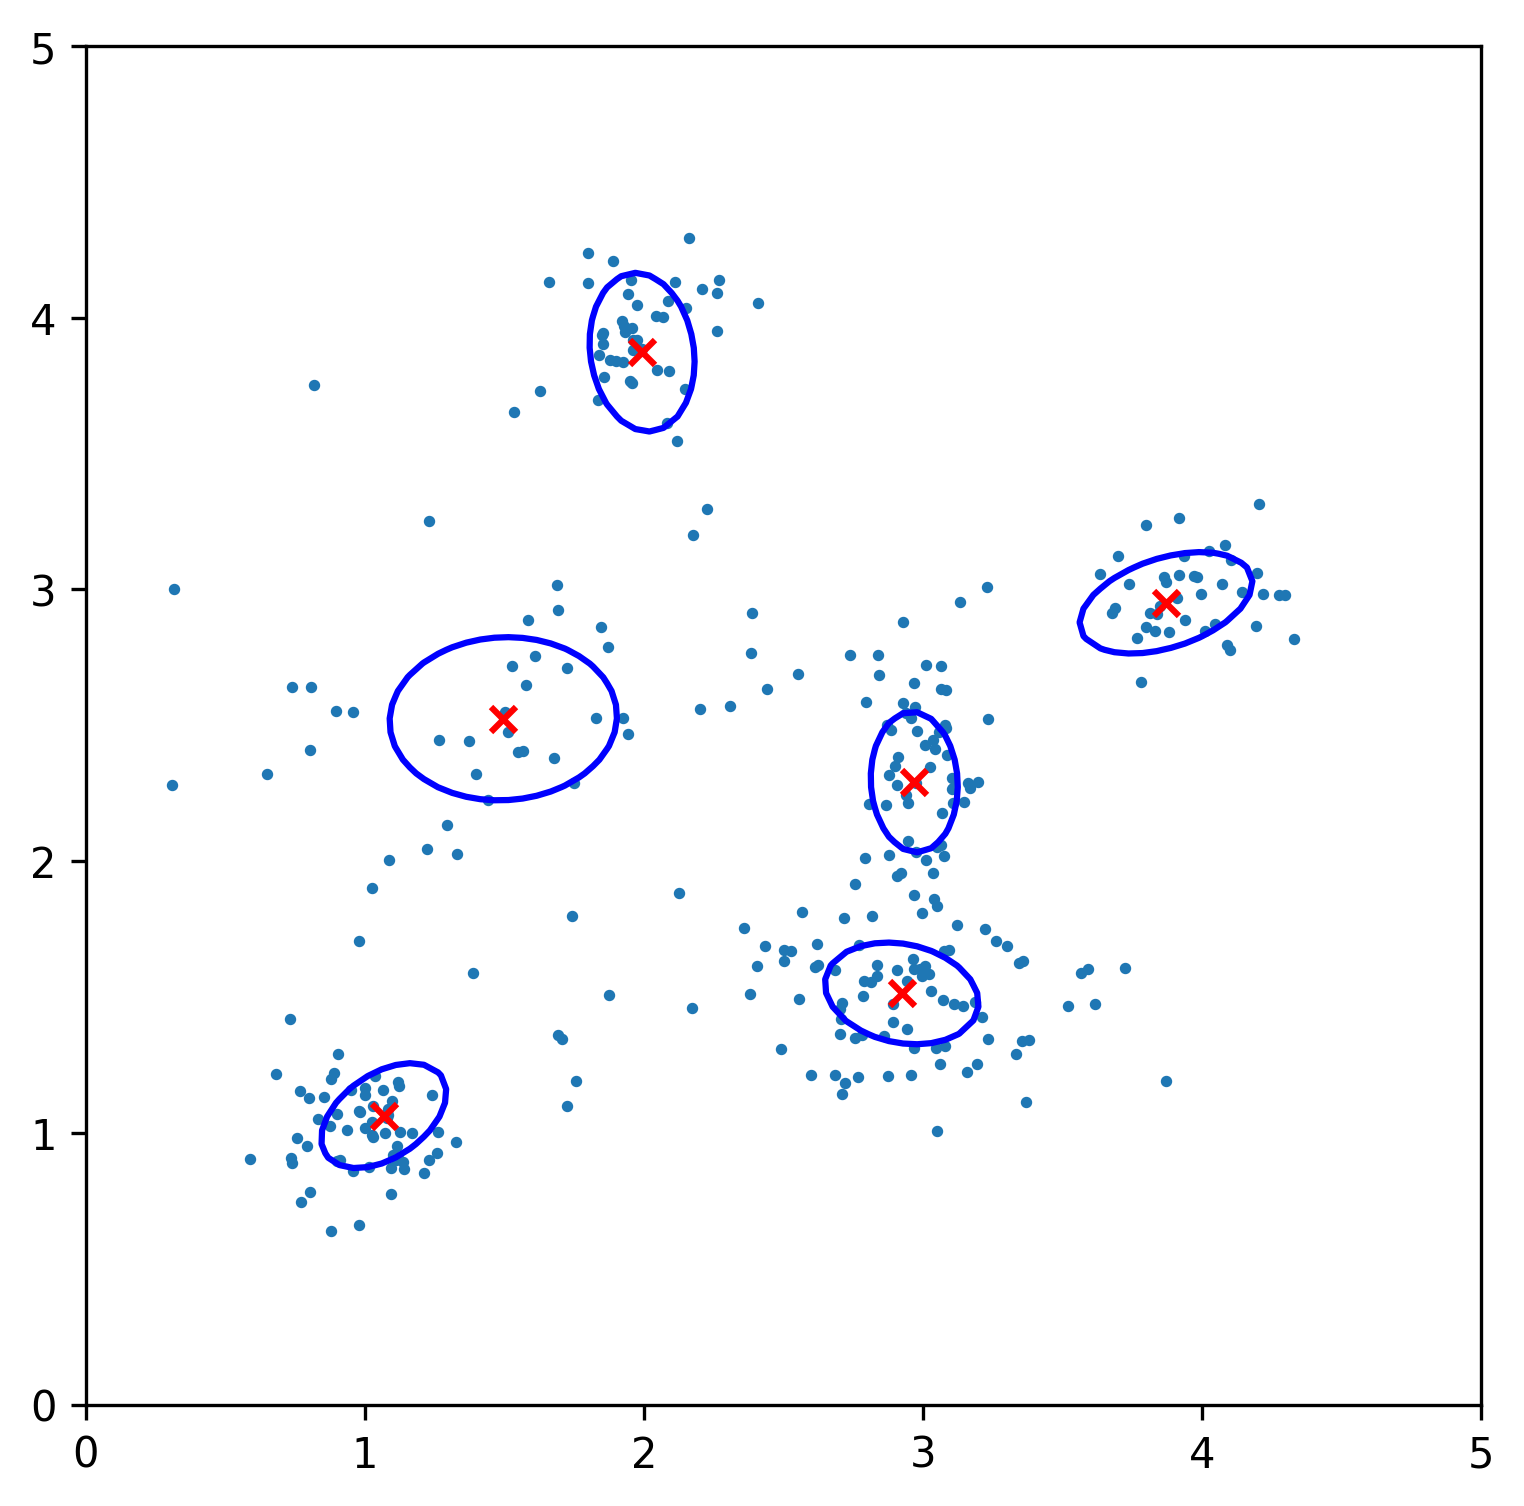

45回目


<Figure size 432x288 with 0 Axes>

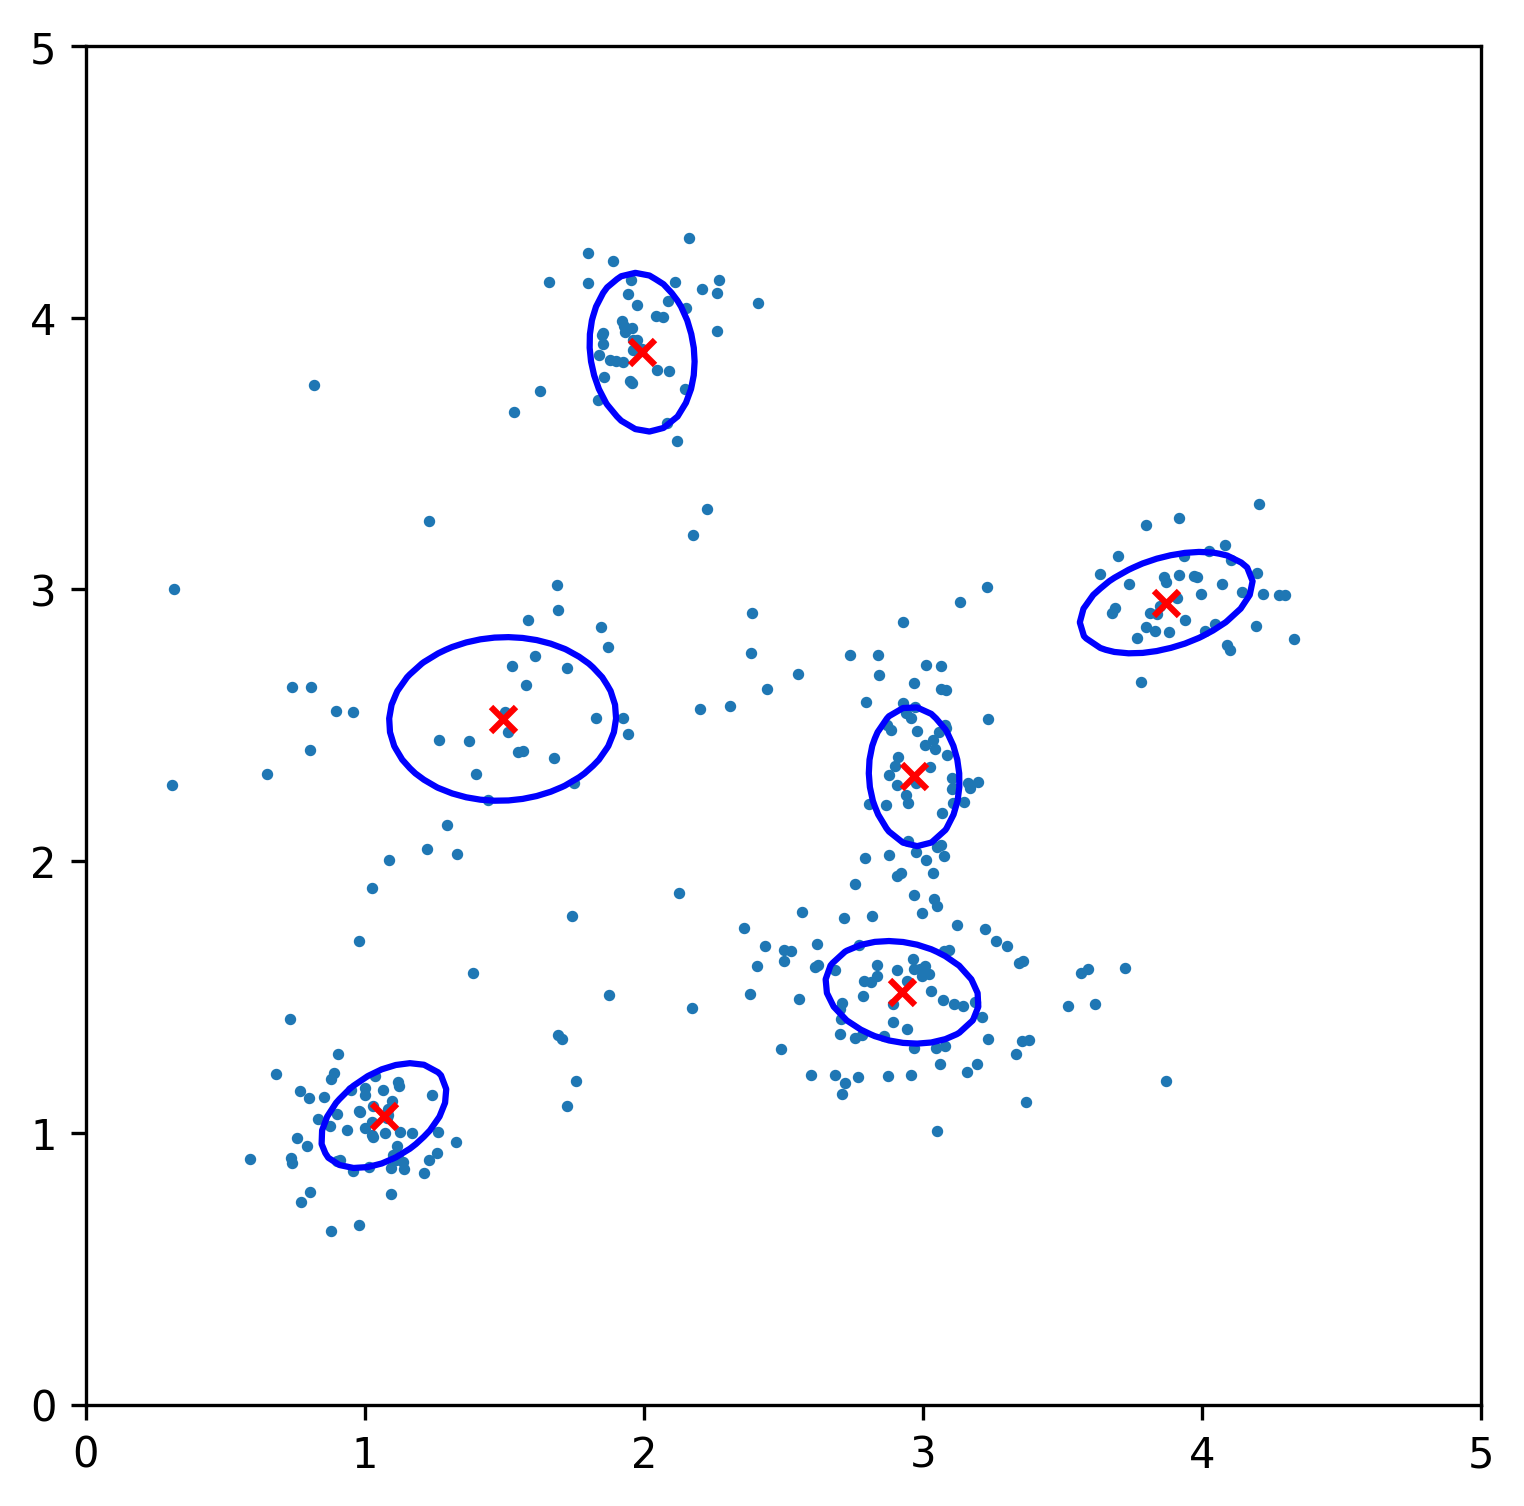

50回目


<Figure size 432x288 with 0 Axes>

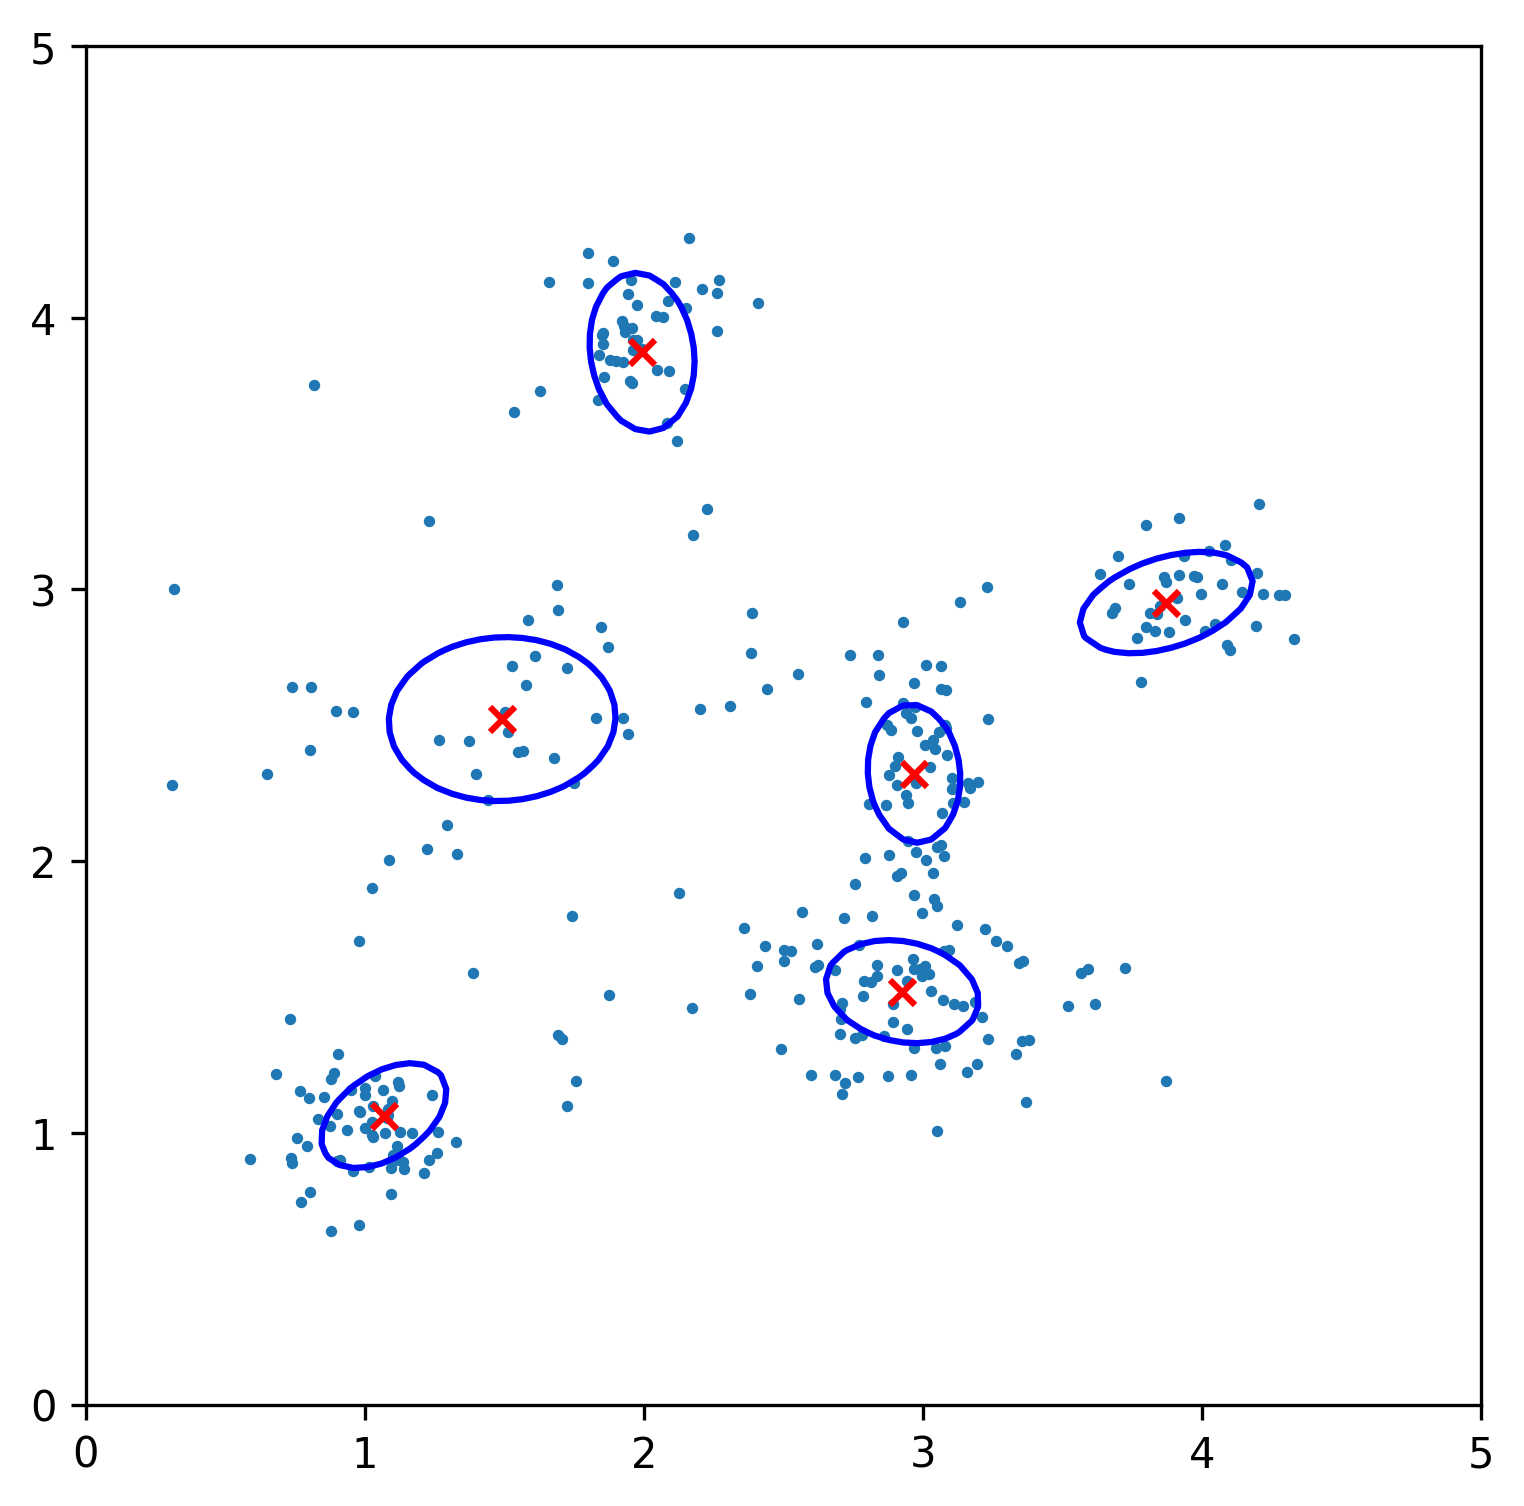

55回目


<Figure size 432x288 with 0 Axes>

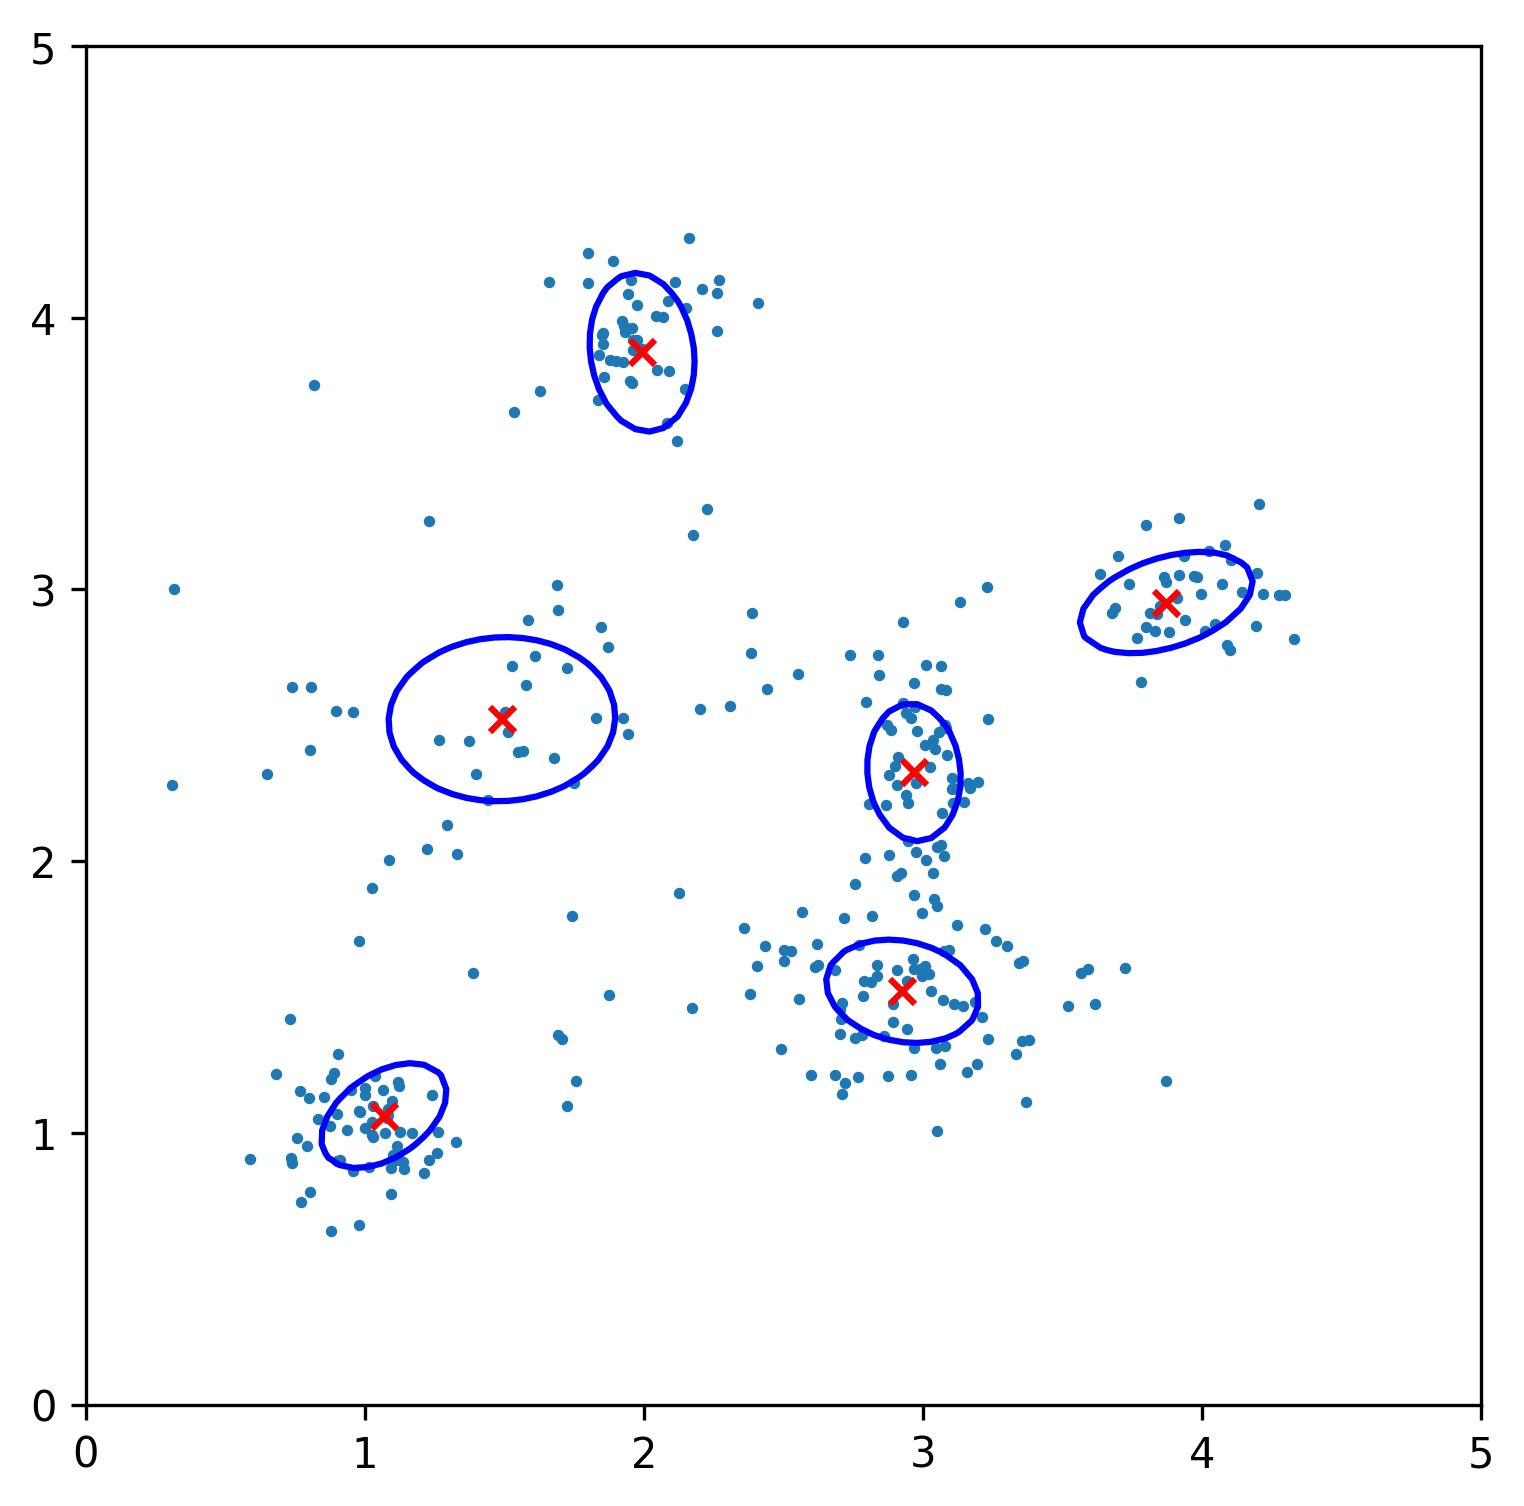

60回目


<Figure size 432x288 with 0 Axes>

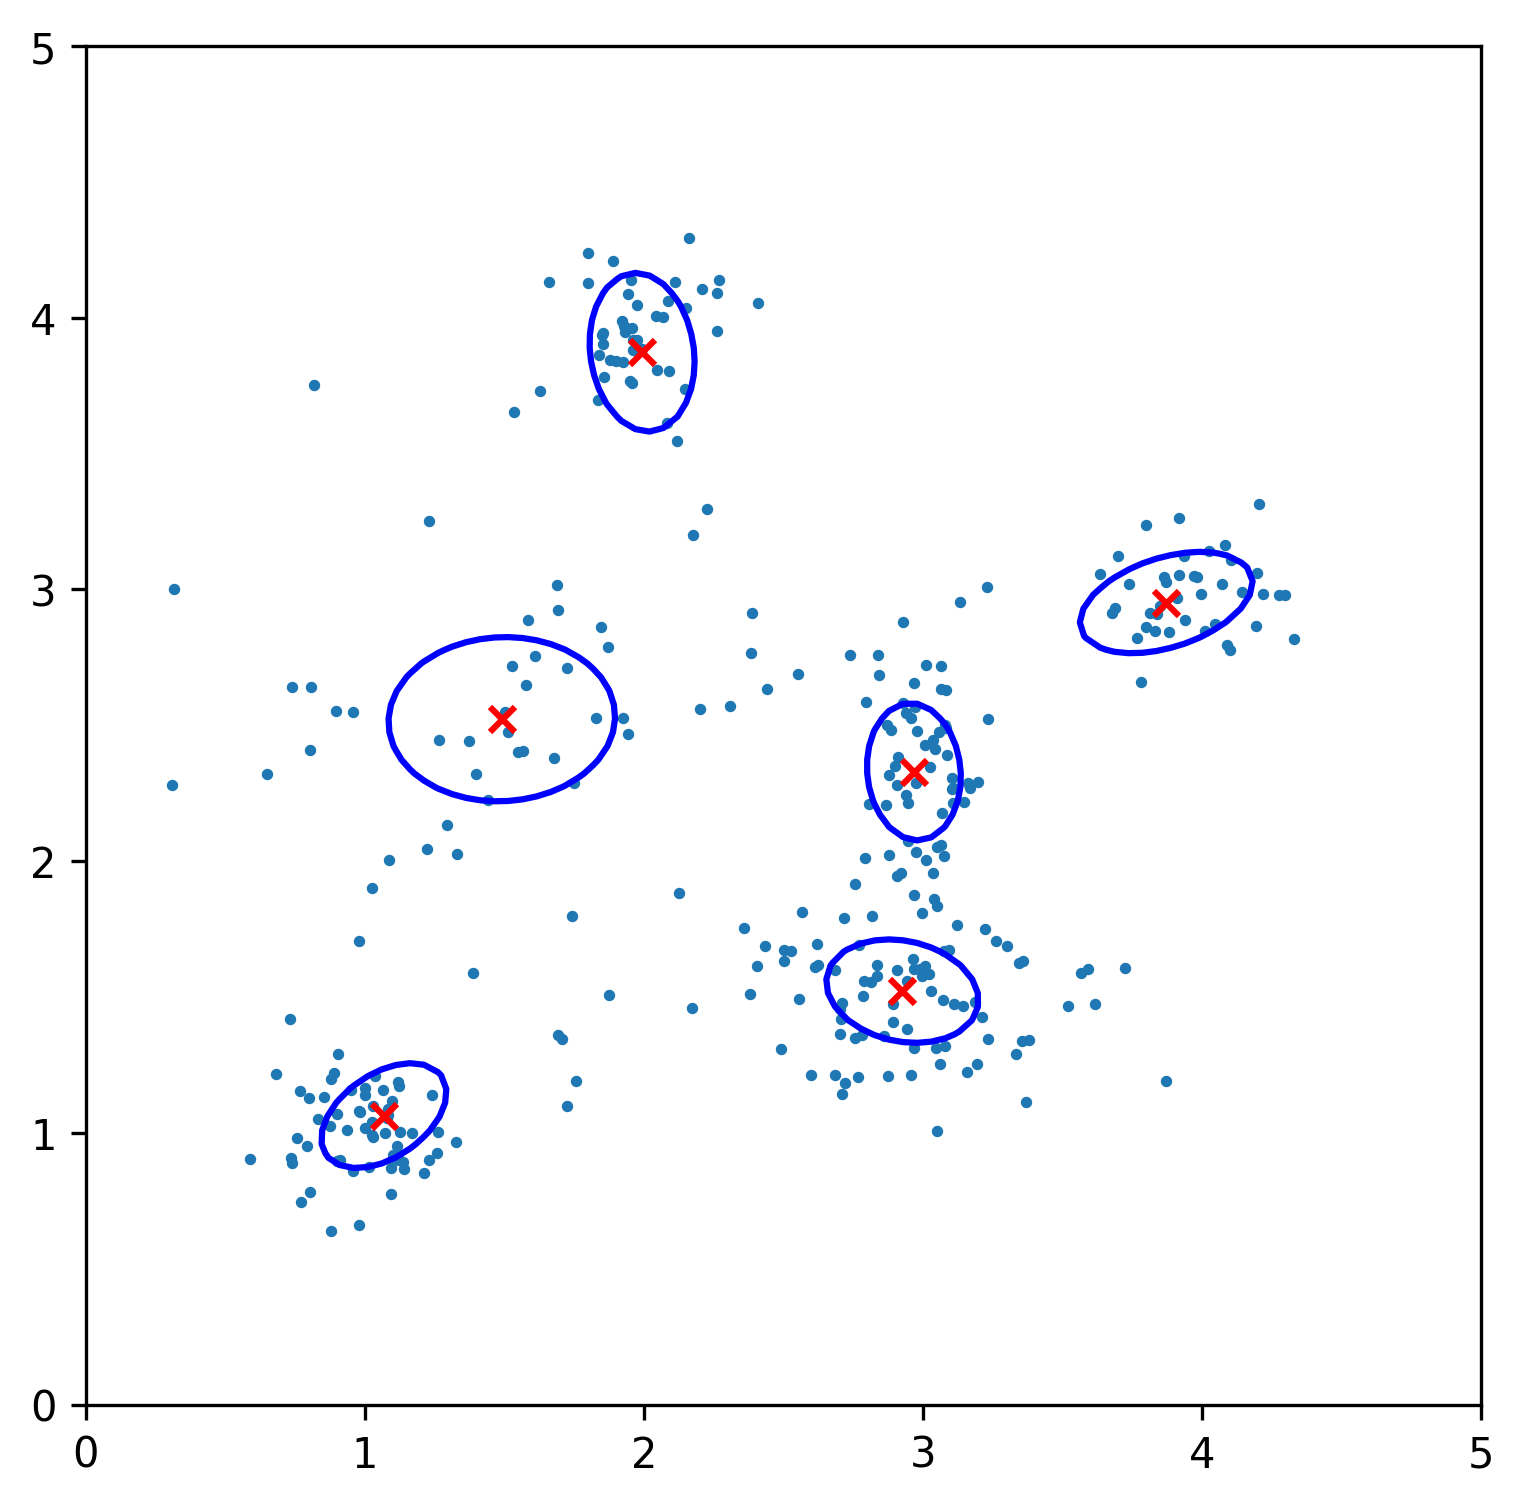

65回目


<Figure size 432x288 with 0 Axes>

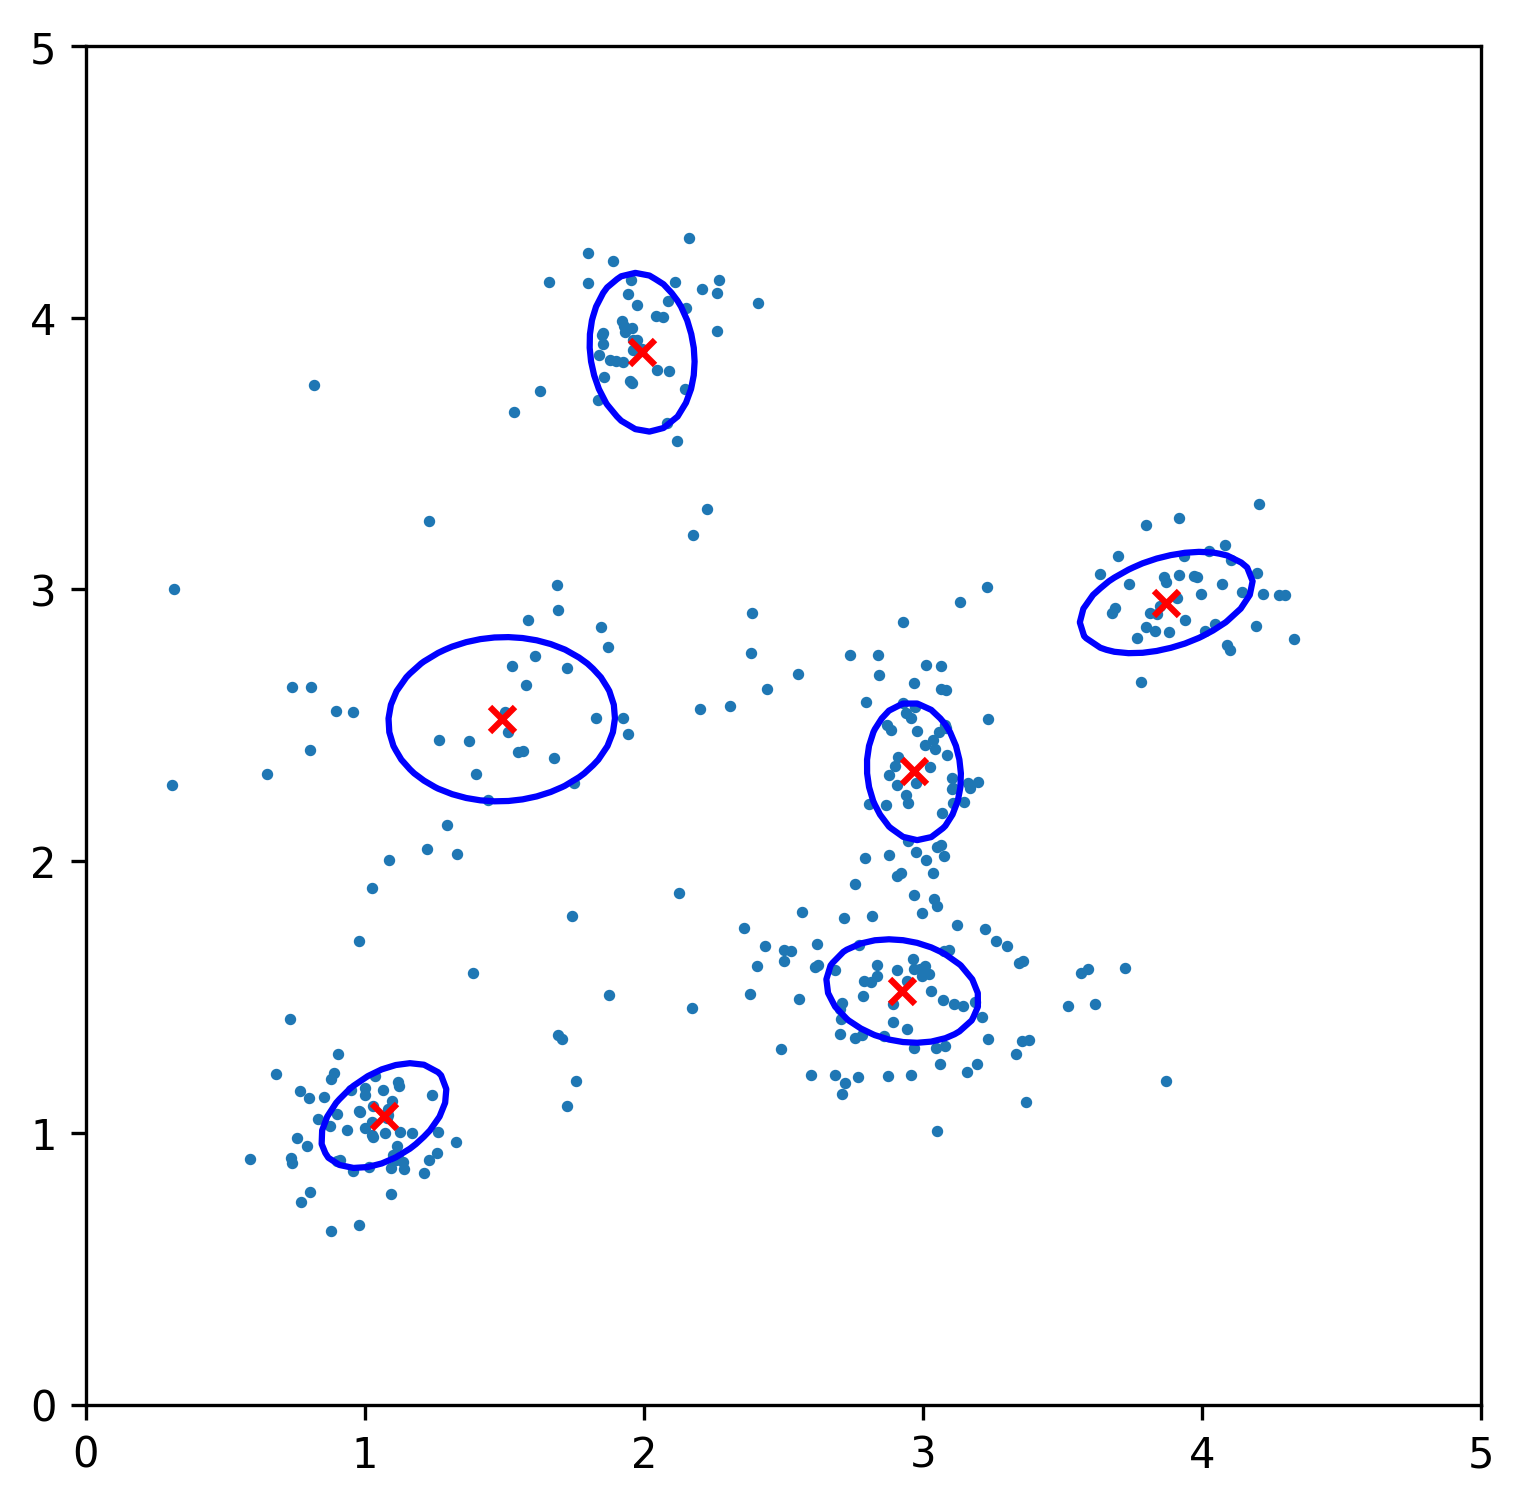

70回目


<Figure size 432x288 with 0 Axes>

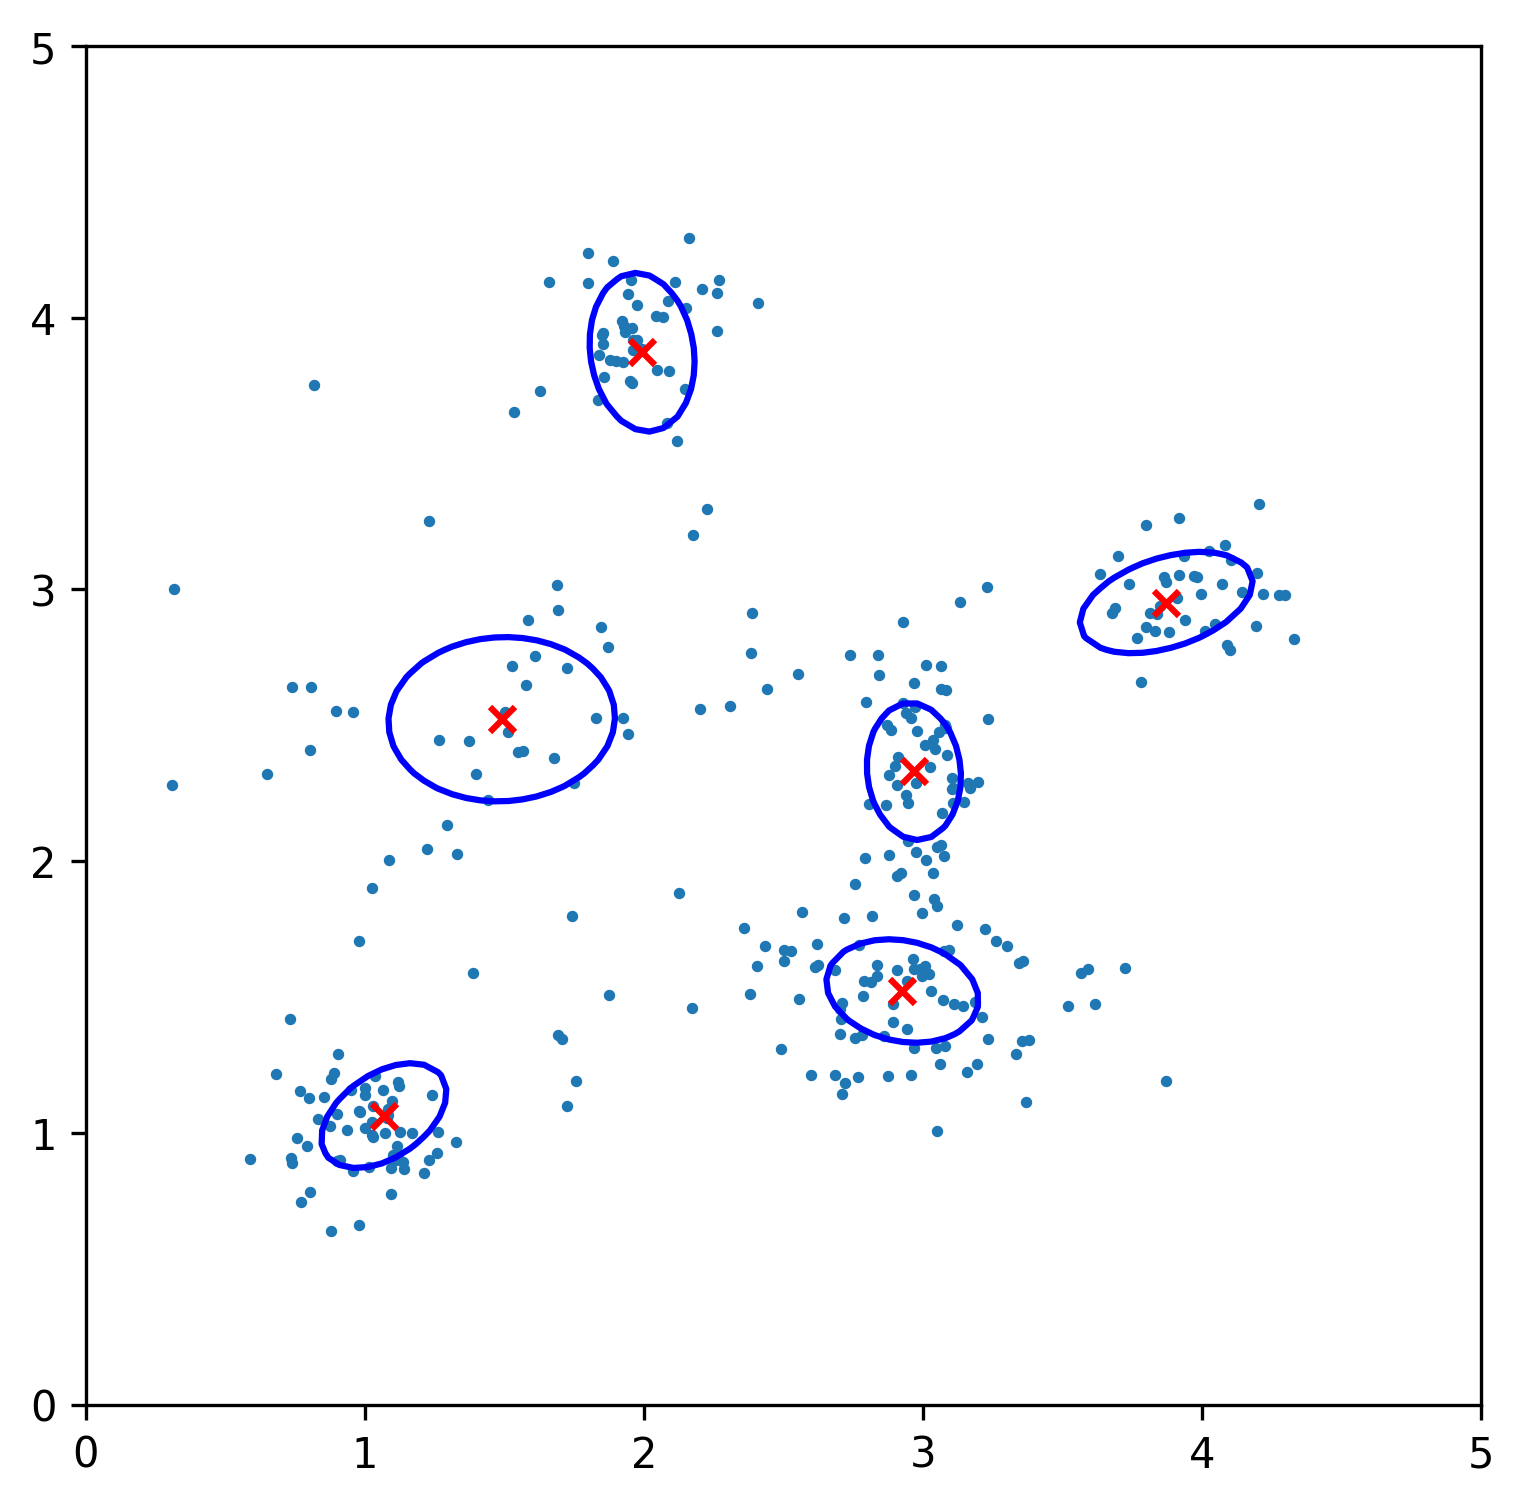

75回目


<Figure size 432x288 with 0 Axes>

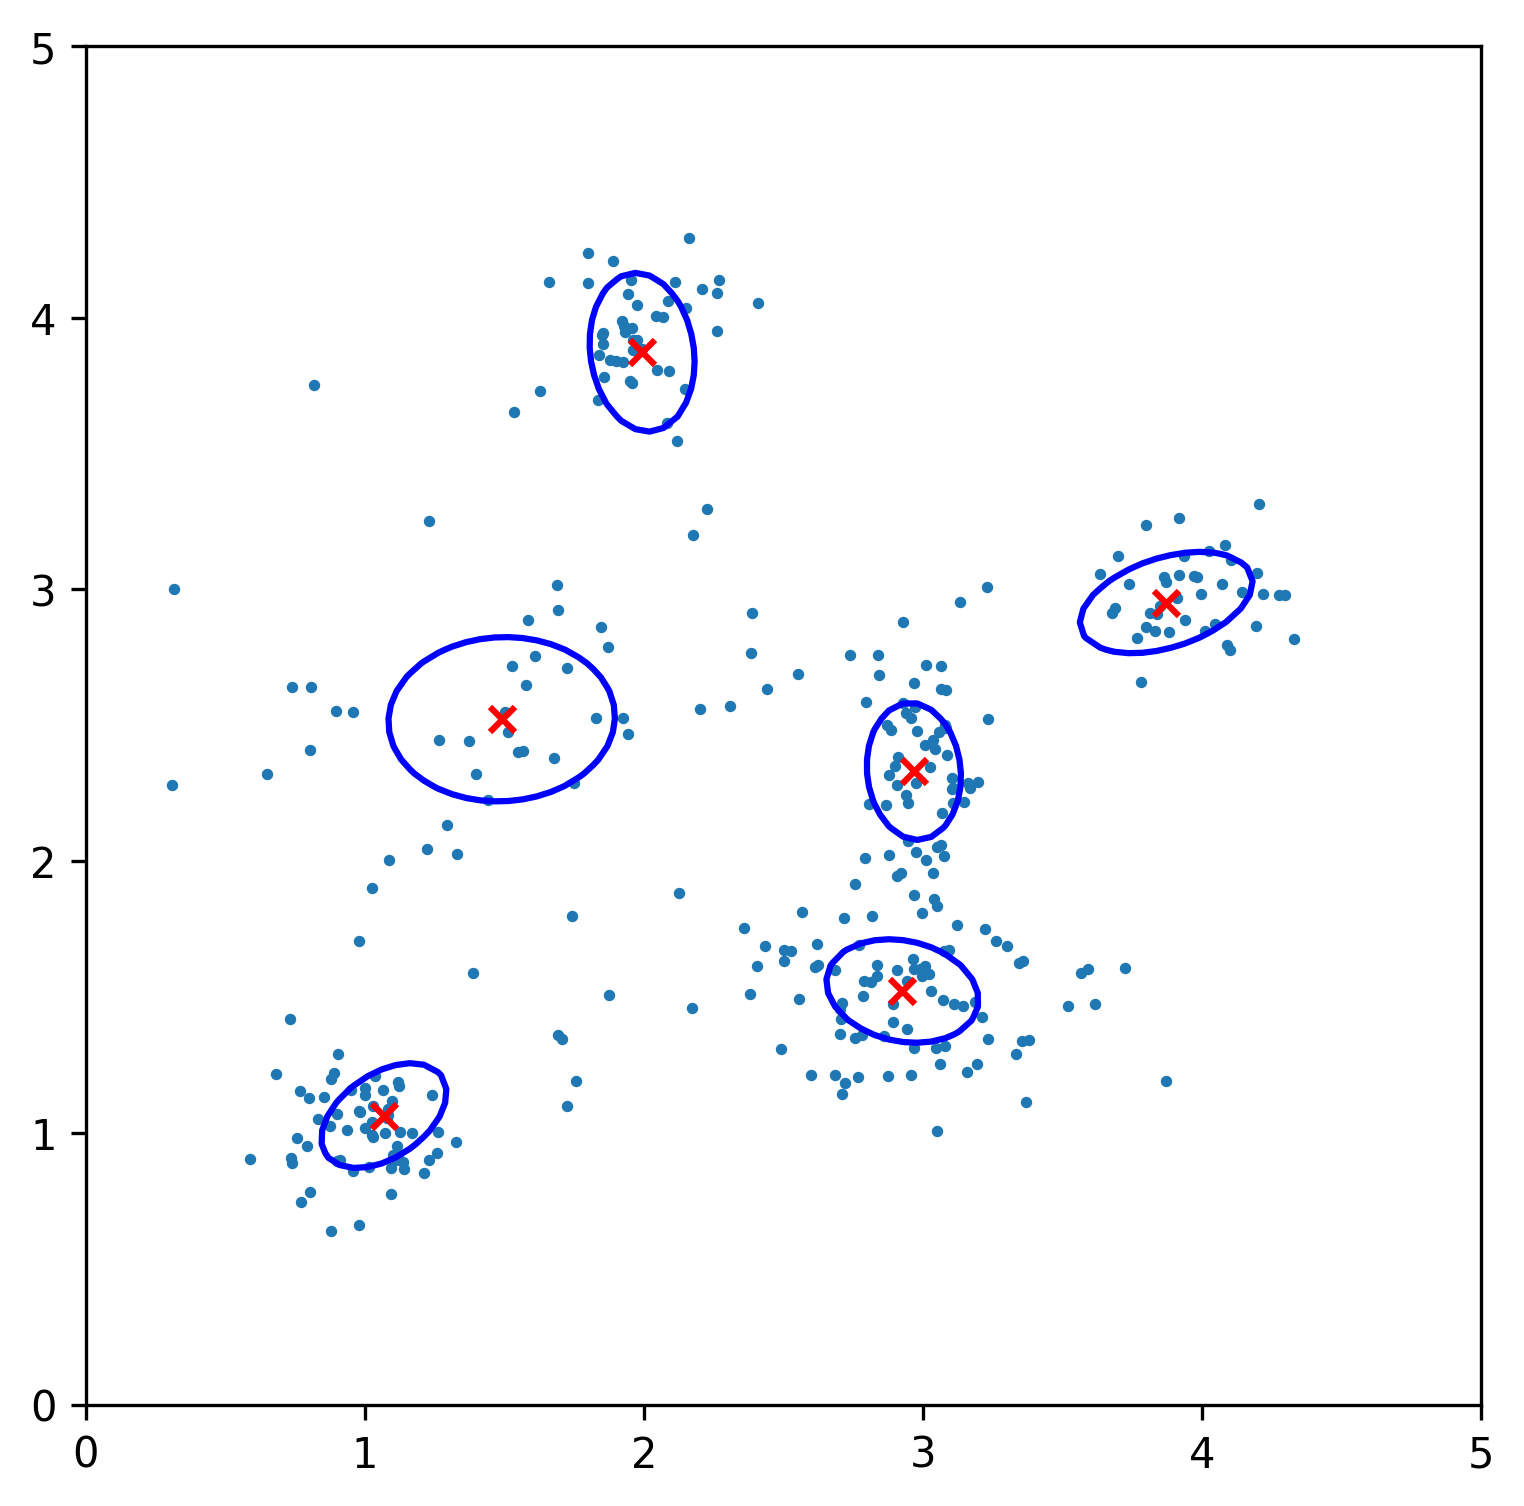

80回目


<Figure size 432x288 with 0 Axes>

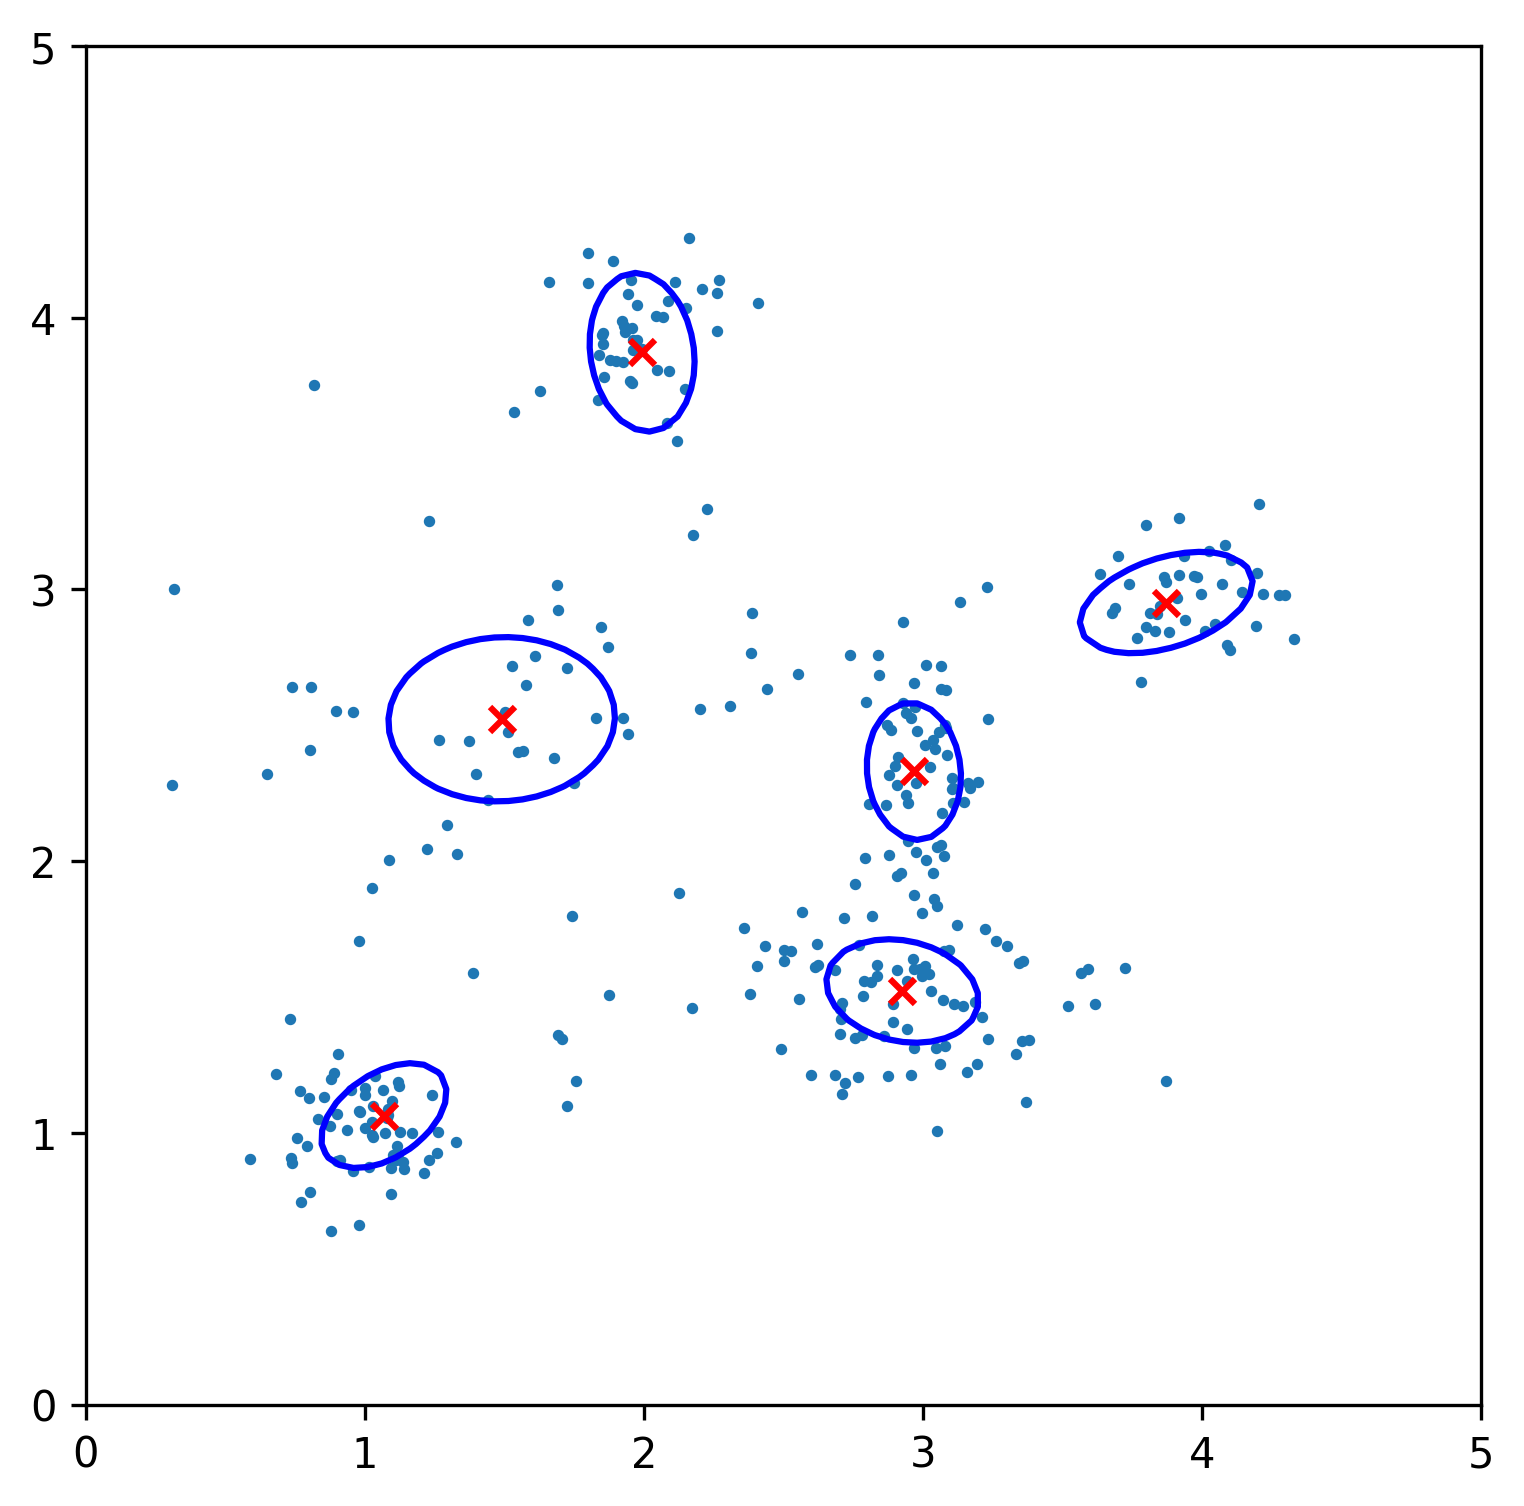

85回目


<Figure size 432x288 with 0 Axes>

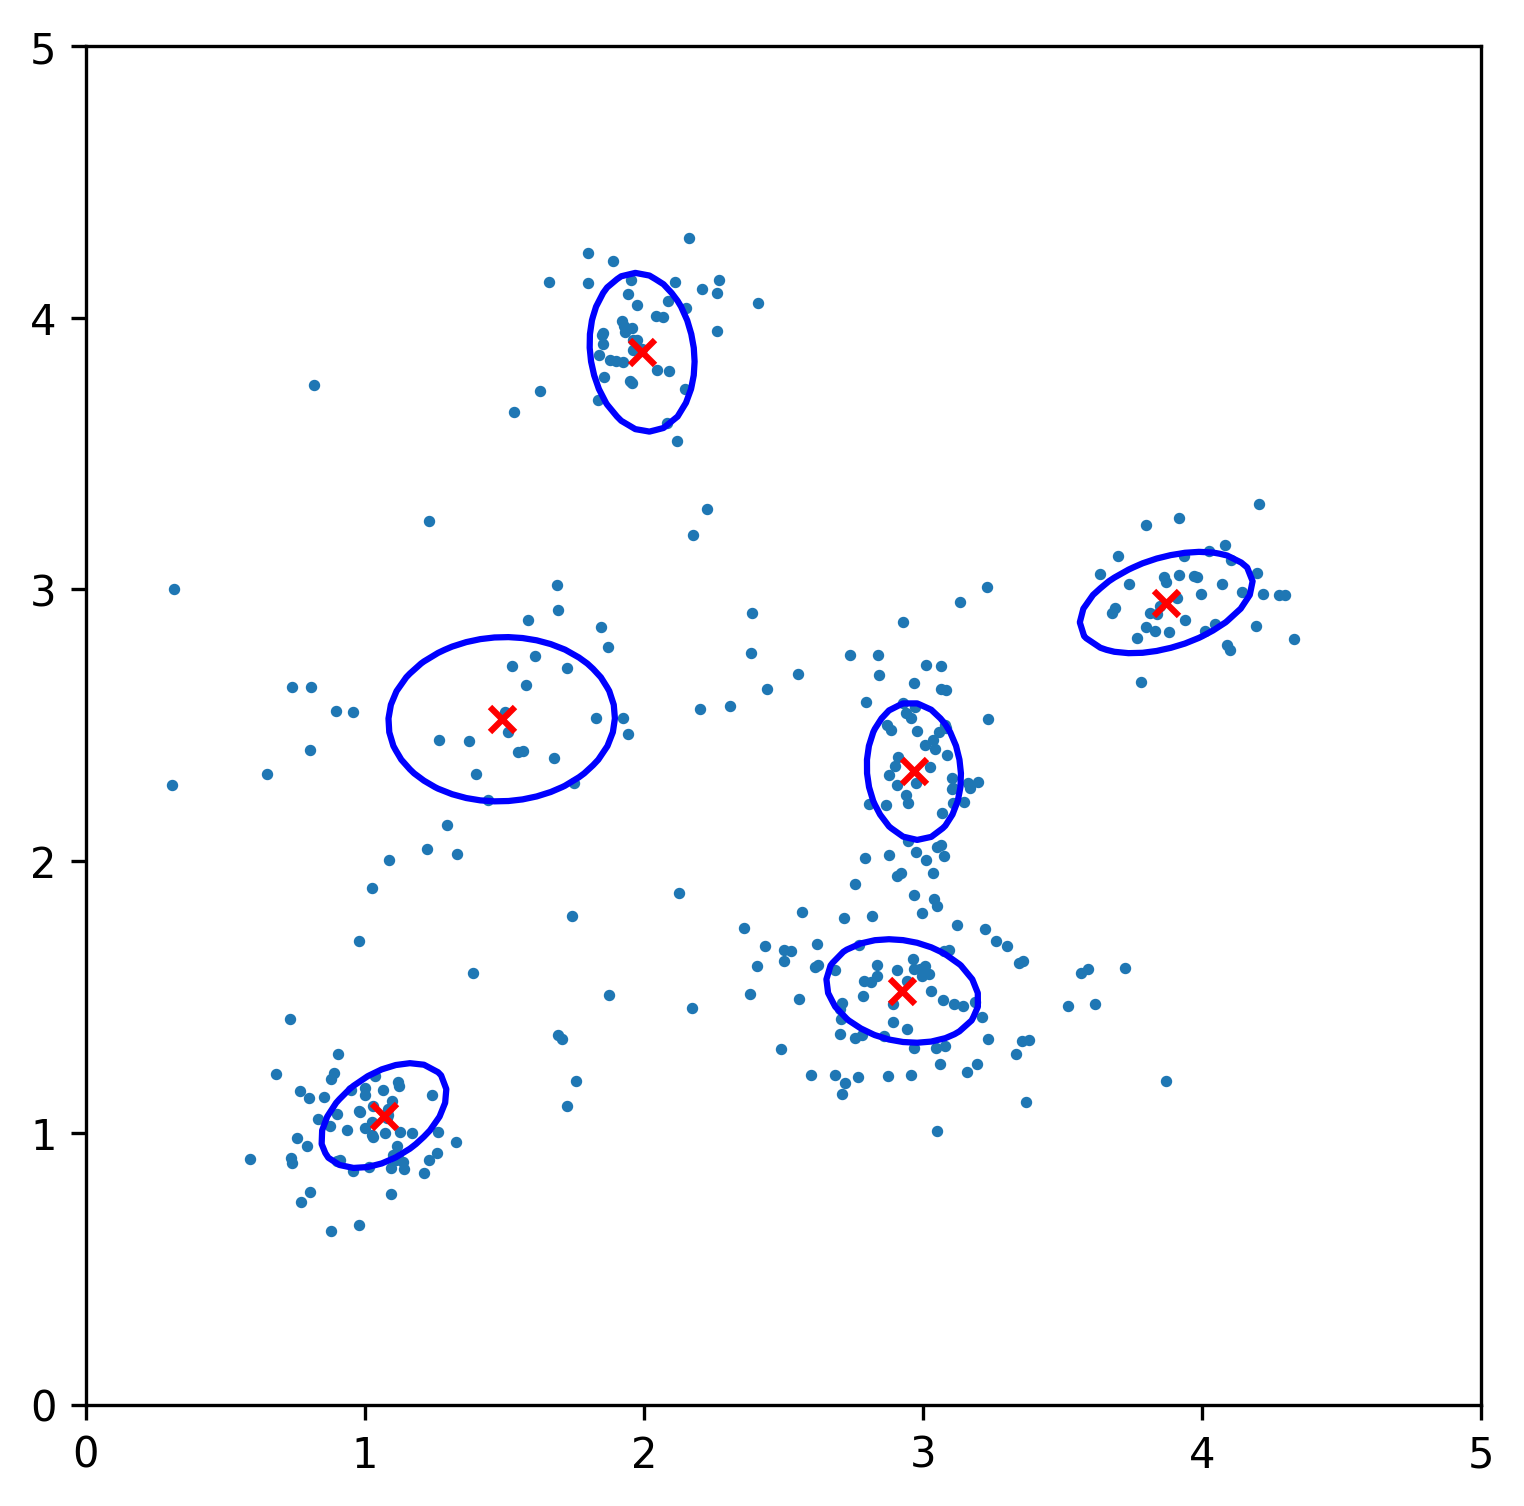

90回目


<Figure size 432x288 with 0 Axes>

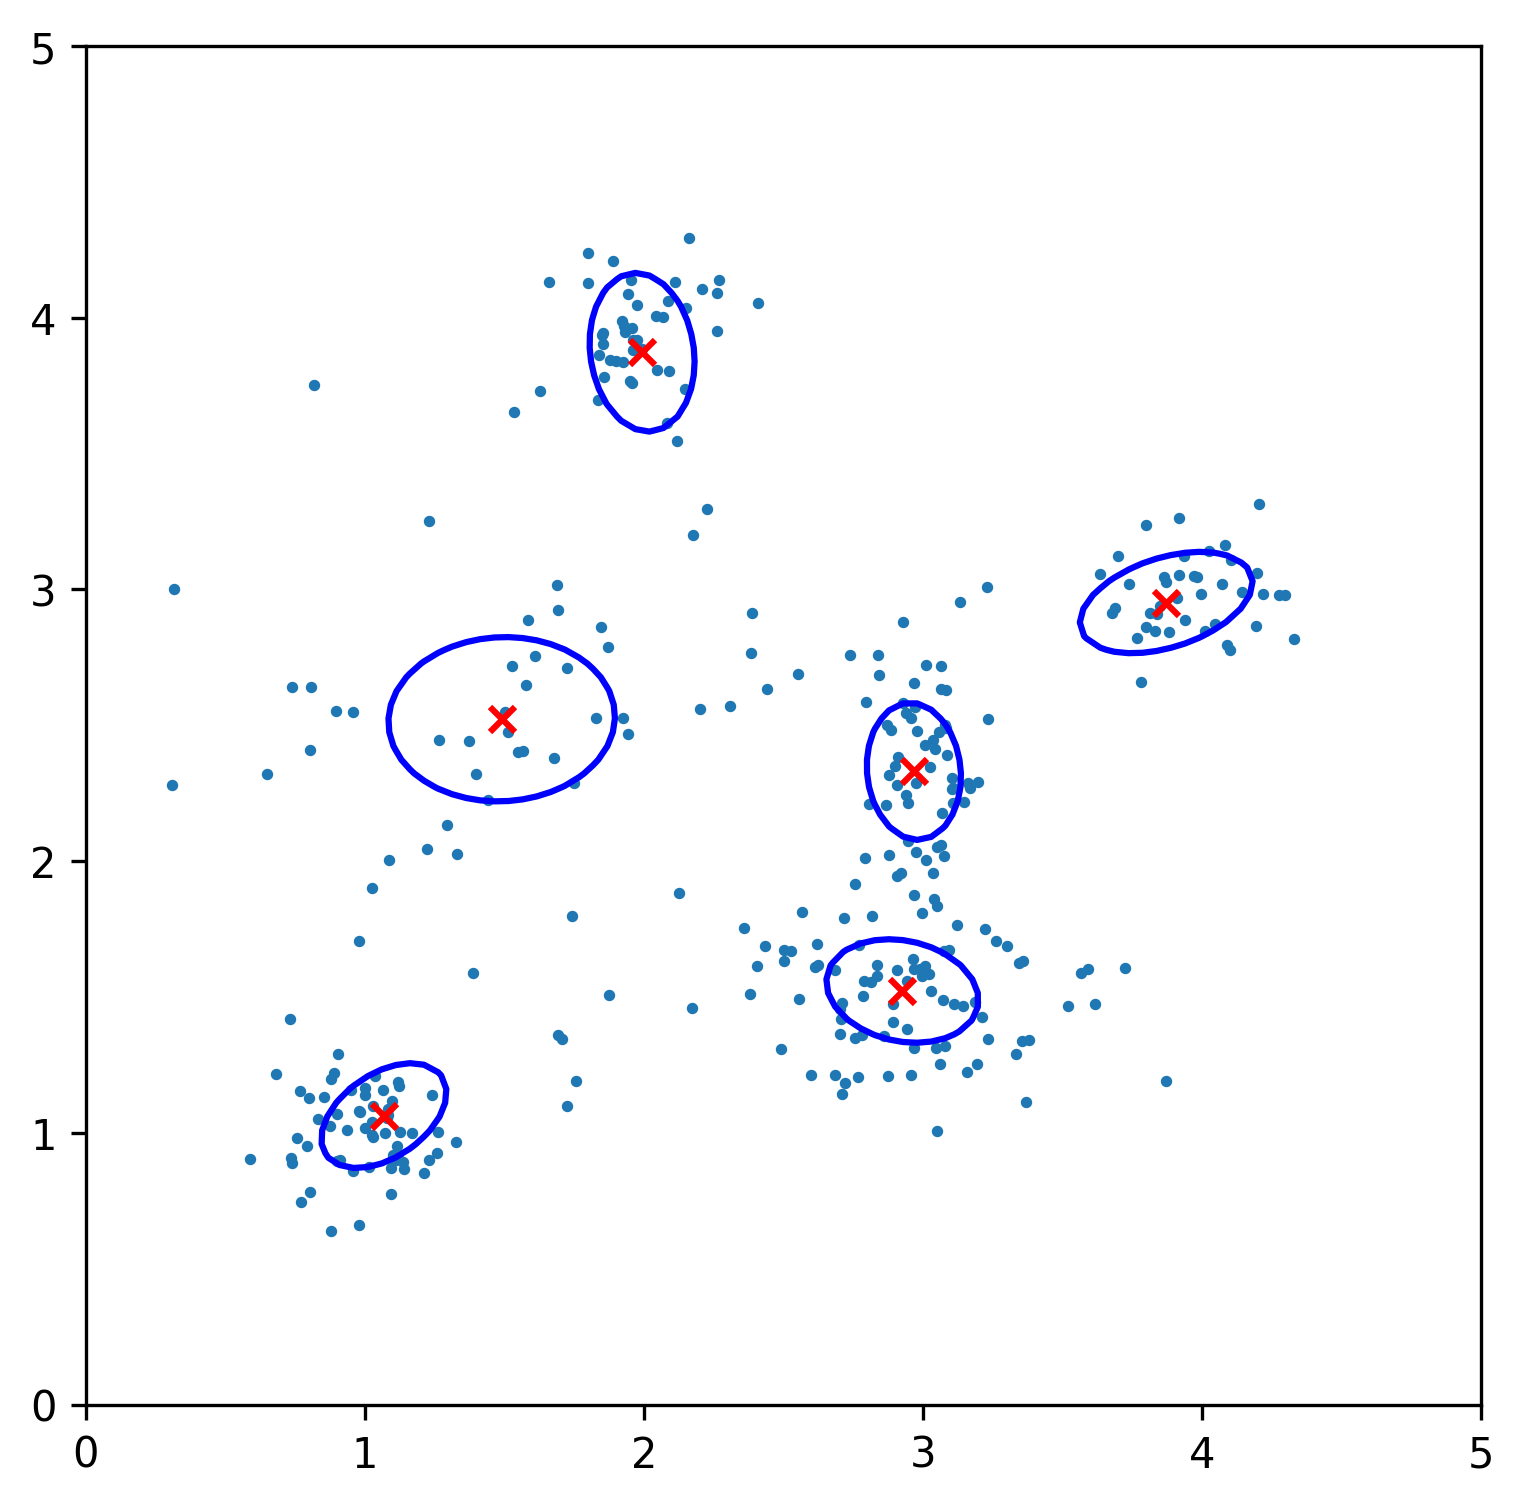

95回目


<Figure size 432x288 with 0 Axes>

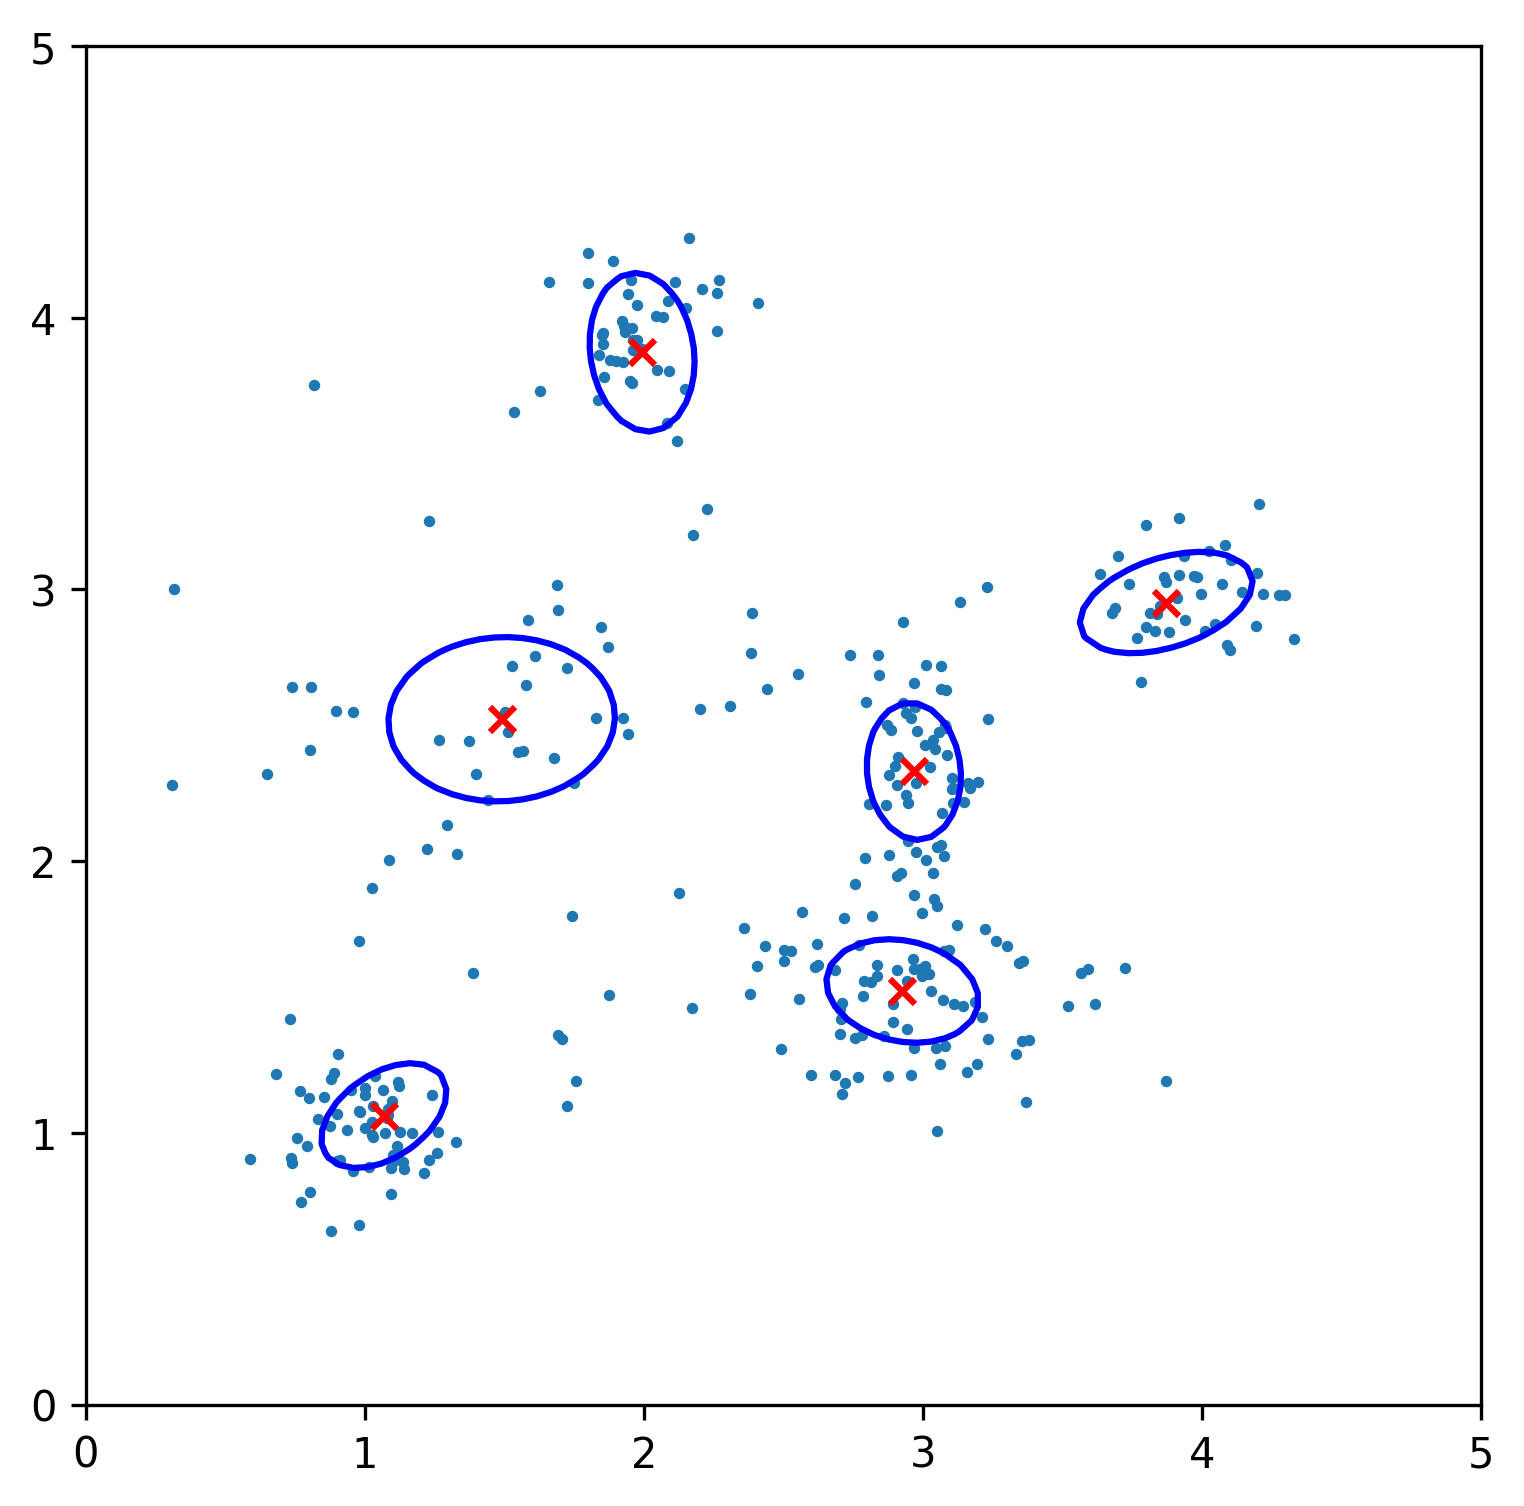

100回目


<Figure size 432x288 with 0 Axes>

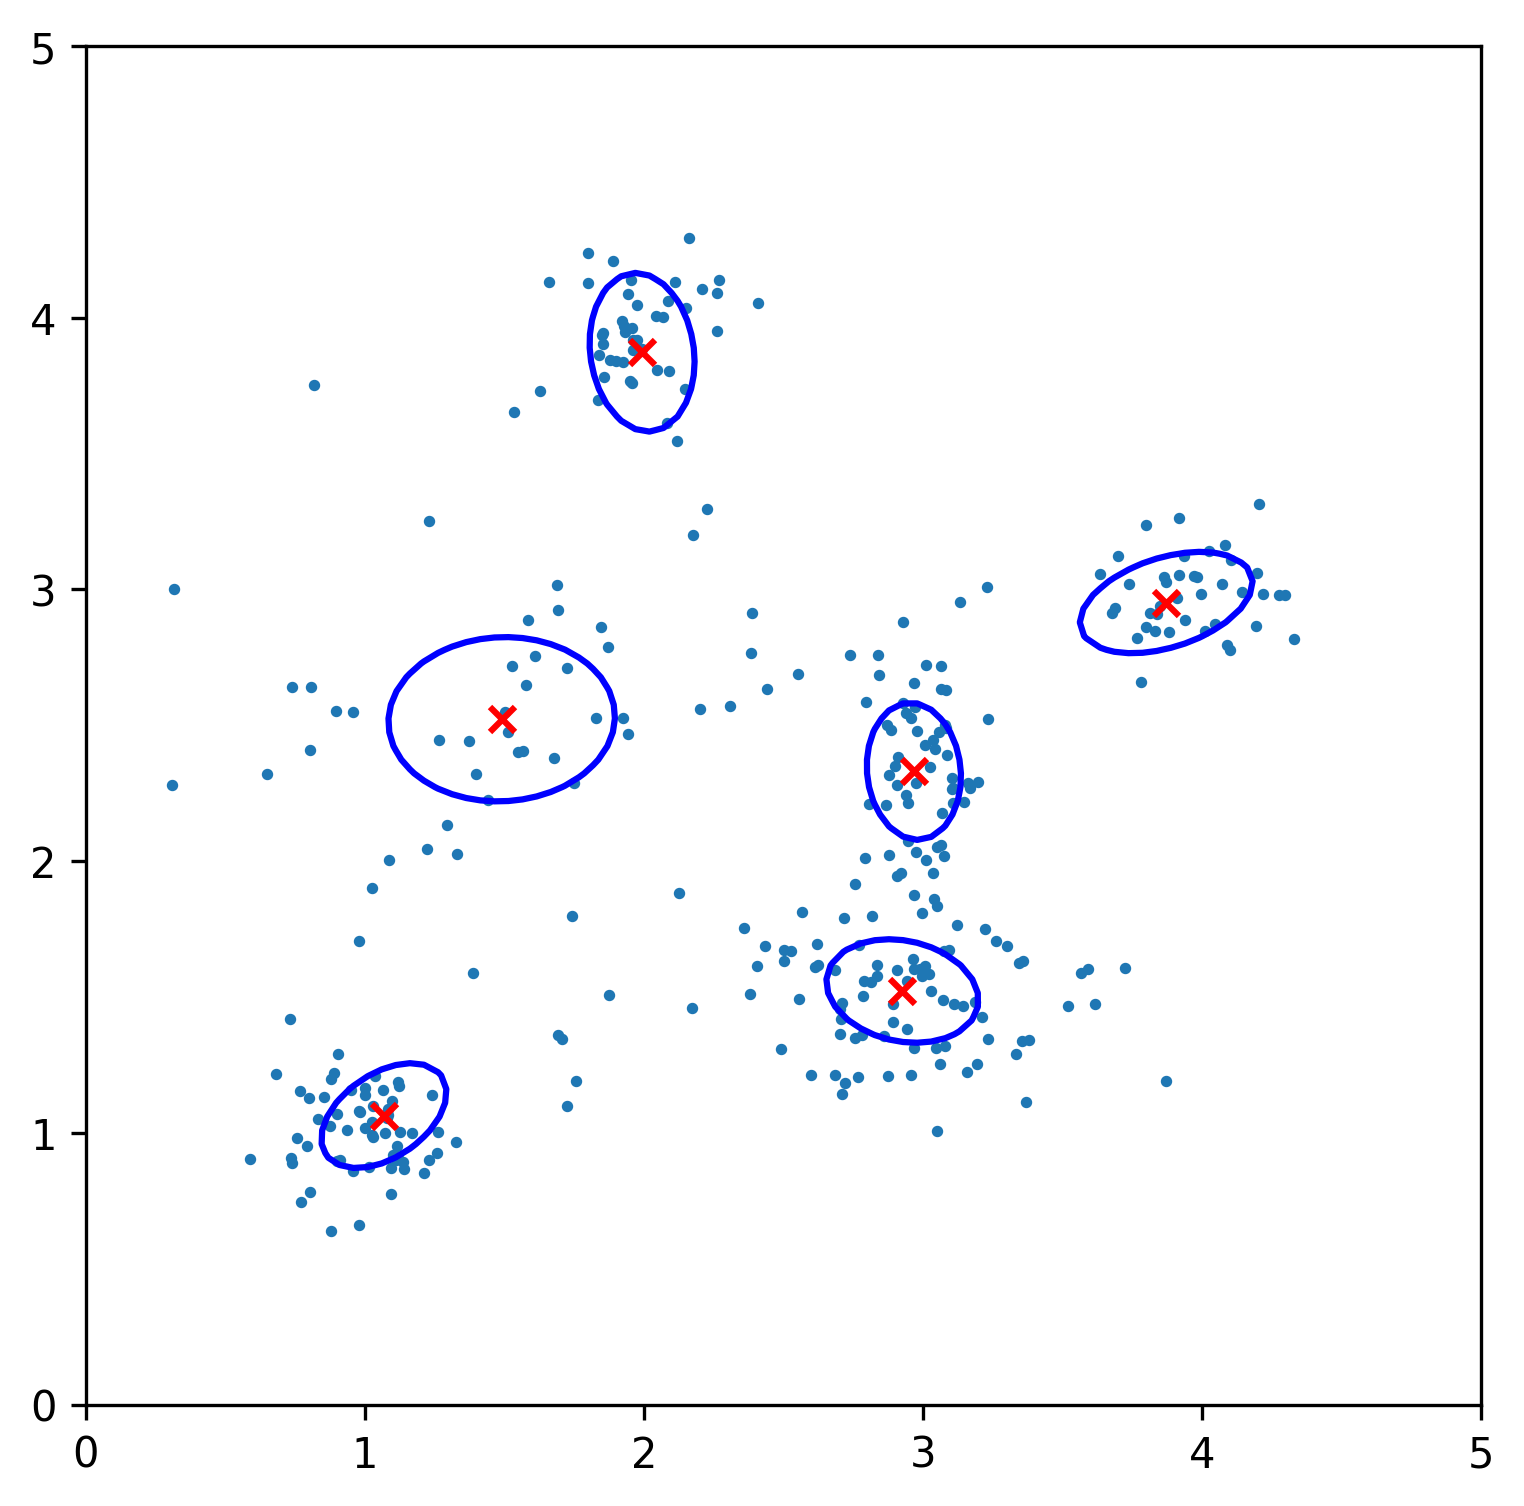

In [13]:
for j in range(20):
    for i in range(5):
        if i==4:
            print("{}回目".format(j*5+5))
        rs = one_step(rs, i==4)